In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 6 2021

@authors: R. van Hoof & A. Lozano
"""

# %matplotlib inline

'\nCreated on Wed May 6 2021\n\n@authors: R. van Hoof & A. Lozano\n'

In [3]:
import time
import os.path
import pickle # needed to store the results
from copy import deepcopy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score as MI
from skopt.utils import use_named_args
from skopt.space import Integer, Categorical, Real
from skopt.utils import cook_initial_point_generator
from skopt import gp_minimize

########################
### Custom functions ###
########################
from ninimplant import pol2cart, get_xyz # matrix rotation/translation ect
from lossfunc import DC, KL, get_yield, hellinger_distance
from electphos import create_grid, reposition_grid, implant_grid, get_phosphenes, prf_to_phos, gen_dummy_phos, get_cortical_magnification, cortical_spread
import visualsectors as gvs

# ignore "True-divide" warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
##########
## INIT ##
##########

# datafolder = '/path/to/data/'
# outputfolder = '/path/to/data/'
# datafolder = 'F:/Rick/Surfdrive_BACKUP/Data/NESTOR/HCP/subjects/'
# datafolder = r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/subjects/'
# outputfolder =  r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/output/'
datafolder = "C:/Users/user/YongtaeC/vimplant0812/data/input/102311/"
outputfolder = "C:/Users/user/YongtaeC/vimplant0812/data/output/102311/"
os.makedirs(outputfolder, exist_ok=True)

# determine range of parameters used in optimization
dim1 = Integer(name='alpha', low=-90, high=90) # visual degrees 
dim2 = Integer(name='beta', low=-15, high=110) # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
dim3 = Integer(name='offset_from_base', low=0, high=40) # in mm
dim4 = Integer(name='shank_length', low=10, high=40) # mm
dimensions = [dim1, dim2, dim3, dim4]

num_calls = 150
x0 = (0,0,20,25) # initial values for the four dimensions
num_initial_points = 10
dc_percentile = 50
n_contactpoints_shank = 10
spacing_along_xy = 1
WINDOWSIZE = 1000

# lists of loss term combinations to loop through
    # Dice Coefficient (1, 0, 0)
    # Yield (0, 1, 0)
    # Hellinger Distance (0, 0, 1)
loss_comb = ([(1, 0.1, 1)]) # weights for loss terms
loss_names = (['dice-yield-HD']) # substring in output filename

# lists of target maps to loop through
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False), 
              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
              gvs.complete_gauss(windowsize=1000, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])
targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# constants pRF model
cort_mag_model = 'wedge-dipole' # which cortex model to use for the cortical magnification
view_angle = 90 #in degrees of visual angle
amp = 100 #stimulation amplitude in micro-amp (higher stimulation -> more tissue activated)

# INIT Bayes
amax = 1
bmax = 1
cmax = 1000
N=5
delta=0.2
thresh=0.05

# subjects to include
subj_list = [118225, 144226, 162935, 176542, 187345, 200614, 251833, 389357, 547046, 671855, 789373, 901139,  
100610, 125525, 145834, 164131, 177140, 191033, 201515, 257845, 393247, 550439, 680957, 814649, 901442, 
102311, 126426, 146129, 164636, 177645, 191336, 203418, 263436, 395756, 552241, 690152, 818859, 905147, 
102816, 128935, 146432, 165436, 177746, 191841, 204521, 283543, 397760, 562345, 706040, 825048, 910241, 
104416, 130114, 146735, 167036, 178142, 192439, 205220, 318637, 401422, 572045, 724446, 826353, 926862, 
105923, 130518, 146937, 167440, 178243, 192641, 209228, 320826, 406836, 573249, 725751, 833249, 927359, 
108323, 131217, 148133, 169040, 178647, 193845, 212419, 330324, 412528, 581450, 732243, 859671, 942658, 
109123, 131722, 150423, 169343, 180533, 195041, 214019, 346137, 429040, 585256, 751550, 861456, 943862, 
111312, 132118, 155938, 169444, 181232, 196144, 214524, 352738, 436845, 601127, 757764, 871762, 951457, 
111514, 134627, 156334, 169747, 181636, 197348, 221319, 360030, 463040, 617748, 765864, 872764, 958976, 
114823, 134829, 157336, 171633, 182436, 198653, 233326, 365343, 467351, 627549, 770352, 878776, 966975, 
115017, 135124, 158035, 172130, 182739, 199655, 239136, 380036, 525541, 638049, 771354, 878877, 971160, 
115825, 137128, 158136, 173334, 185442, 200210, 246133, 381038, 536647, 644246, 782561, 898176, 973770, 
116726, 140117, 159239, 175237, 186949, 200311, 249947, 385046, 541943, 654552, 783462, 899885, 995174, 'fsaverage']

subj_list = [100206]
subj_list = [102311]

In [5]:
################################################
## Functions related to Bayesian optimization ##
################################################

def custom_stopper(res, N=5, delta=0.2, thresh=0.05):
    '''
    Returns True (stops the optimization) when 
    the difference between best and worst of the best N are below delta AND the best is below thresh
    
    N = last number of cost values to track
    delta = ratio best and worst
    
    '''
    
    if len(res.func_vals) >= N:
        func_vals = np.sort(res.func_vals)
        worst = func_vals[N - 1]
        best = func_vals[0]
        
        return (abs((best - worst)/worst) < delta) & (best < thresh)
    else:
        return None

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creats a grid based on the four parameters. 
    * Phosphenes are generated based on the grid's contact points, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
      The function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values and prints diagnostic information. 
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
    
    # implanting grid
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)    
    phosphenes = get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image    
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)    
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()

    # bin_thesh determines size target
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) 

    # compute dice coefficient -> should be 1 -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())    
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    return cost

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density):
    '''
    Copy from f, to obtain phosphene map and contact points for the optimized parameters. Used to visualize results.

    also returns coords used ect.
    '''
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)

    # implanting grid
    ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    phosphenes =    get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model)
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32')
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    print(view_angle)
    
    # can we relate bin_thesh to an eccentricity value? -> taken care of by masking the targets -> CHANGE TO 0.99999
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) # bin_thesh determines size target

    # compute dice coefficient -> should be large -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)  
    
    # very important to normalize target density to same range as phospheneMap!
    target_density /= target_density.max()
    target_density /= target_density.sum()        
    
    # compute Hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    return grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap

number of subjects: 1
target:  targ-upper
loss:  dice-yield-HD
a,b,c:  1 0.1 1
102311   LH   targ-upper   dice-yield-HD  already processed.
102311   RH   targ-upper   dice-yield-HD  already processed.
target:  targ-lower
loss:  dice-yield-HD
a,b,c:  1 0.1 1
102311   LH   targ-lower   dice-yield-HD  already processed.
102311   RH   targ-lower   dice-yield-HD  already processed.
target:  targ-inner
loss:  dice-yield-HD
a,b,c:  1 0.1 1
102311   LH   targ-inner   dice-yield-HD  already processed.
102311   RH   targ-inner   dice-yield-HD  already processed.
target:  targ-full
loss:  dice-yield-HD
a,b,c:  1 0.1 1
102311   LH   targ-full   dice-yield-HD  already processed.
102311   RH   targ-full   dice-yield-HD  already processed.


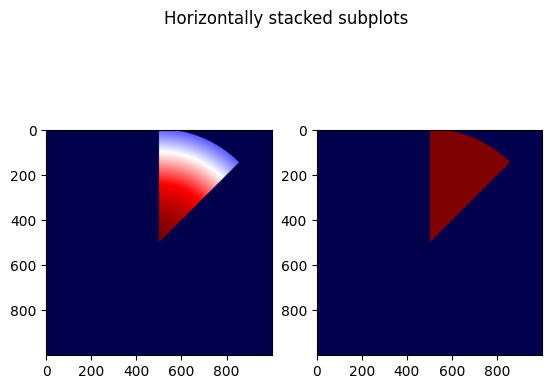

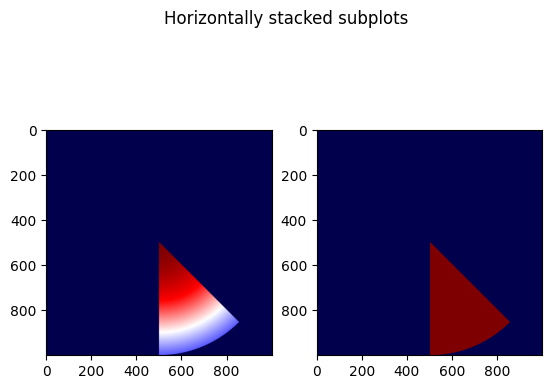

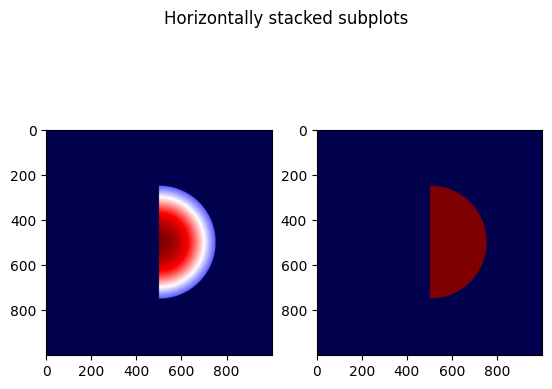

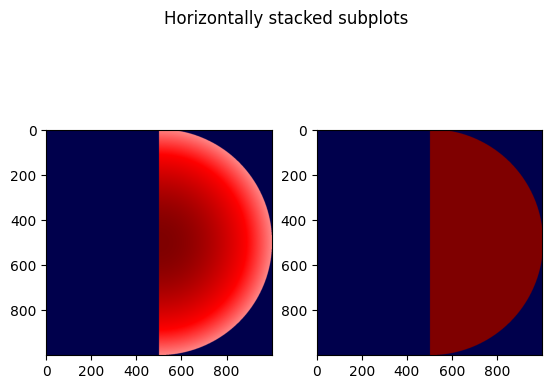

In [6]:
###################
## Main Sim Loop ##
###################

# set file names
fname_ang = 'inferred_angle.mgz'
fname_ecc = 'inferred_eccen.mgz'
fname_sigma = 'inferred_sigma.mgz'
fname_anat = 'T1.mgz'
fname_aparc = 'aparc+aseg.mgz'
fname_label = 'inferred_varea.mgz'
print('number of subjects: ' + str(len(subj_list)))

# set beta angle constraints according to hemisphere
dim2_lh = Integer(name='beta', low=-15, high=110)
dim2_rh = Integer(name='beta', low=-110, high=15)

# loop through phosphene target maps and combinations of loss terms
for target_density, ftarget in zip(targ_comb, targ_names):
    for (a, b, c), floss in zip(loss_comb, loss_names):
        # set target
        target_density /= target_density.max()
        target_density /= target_density.sum()
        # can we relate bin_thesh to an eccentricity value?
        bin_thresh=np.percentile(target_density, dc_percentile ) #np.min(target_density) # bin_thesh determines size target
        target_density_bin = (target_density > bin_thresh).astype(bool)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        plt.subplot(1,2,1).imshow(target_density, cmap = 'seismic')
        plt.subplot(1,2,2).imshow(target_density_bin, cmap = 'seismic')

        for s in subj_list:
            # data_dir = datafolder + str(s)+ '/T1w/' + str(s) + '/mri/'            
            data_dir = datafolder

            if s == 'fsaverage':
                data_dir = datafolder + str(s) + '/mri/'
                
            # load maps
            ang_img = nib.load(data_dir+fname_ang)
            polar_map = ang_img.get_fdata()
            ecc_img = nib.load(data_dir+fname_ecc)
            ecc_map = ecc_img.get_fdata()
            sigma_img = nib.load(data_dir+fname_sigma)
            sigma_map = sigma_img.get_fdata()                
            aparc_img = nib.load(data_dir+fname_aparc)
            aparc_roi = aparc_img.get_fdata()
            label_img = nib.load(data_dir+fname_label)
            label_map = label_img.get_fdata()

            # compute valid voxels
            dot = (ecc_map * polar_map)
            good_coords = np.asarray(np.where(dot != 0.0))

            # filter gm per hemisphere
            cs_coords_rh = np.where(aparc_roi == 1021)
            cs_coords_lh = np.where(aparc_roi == 2021)
            gm_coords_rh = np.where((aparc_roi >= 1000) & (aparc_roi < 2000))
            gm_coords_lh = np.where(aparc_roi > 2000)
            xl,yl,zl = get_xyz(gm_coords_lh)
            xr,yr,zr = get_xyz(gm_coords_rh)
            GM_LH = np.array([xl,yl,zl]).T
            GM_RH = np.array([xr,yr,zr]).T

            # extract labels
            V1_coords_rh = np.asarray(np.where(label_map == 1))
            V1_coords_lh = np.asarray(np.where(label_map == 1))
            V2_coords_rh = np.asarray(np.where(label_map == 2))
            V2_coords_lh = np.asarray(np.where(label_map == 2))
            V3_coords_rh = np.asarray(np.where(label_map == 3))
            V3_coords_lh = np.asarray(np.where(label_map == 3))

            # divide V1 coords per hemisphere
            good_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            good_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V1_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V1_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V2_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V2_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V3_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V3_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T           

            # find center of left and right calcarine sulci
            median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
            median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]

            # get GM mask and compute dorsal/posterior planes
            gm_mask = np.where(aparc_roi != 0)
            print('target: ', ftarget)
            print('loss: ', floss)
            print('a,b,c: ', a,b,c)

            # apply optimization to each hemisphere
            for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip([GM_LH, GM_RH], ['LH', 'RH'], [median_lh, median_rh], [good_coords_lh, good_coords_rh], [V1_coords_lh, V1_coords_rh], [V2_coords_lh, V2_coords_rh], [V3_coords_lh, V3_coords_rh], [dim2_lh, dim2_rh]):        
                
                # check if already done
                data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget
                fname = outputfolder + data_id + '.pkl'
                if os.path.exists(fname):
                    print(str(s), ' ', str(hem), ' ',  str(ftarget), ' ', str(floss), ' already processed.')
                else:
                    dimensions = [dim1, dim2, dim3, dim4]

                    # create initial point generator
                    lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

                    # optimize
                    res = gp_minimize(f, x0=x0, dimensions=dimensions, n_jobs=-1, n_calls=num_calls, n_initial_points=num_initial_points, initial_point_generator=lhs2, callback=[custom_stopper])

                    # print results
                    # print('subject ', s, ' ', hem)
                    # print('best alpha:', res.x[0])
                    # print('best beta:',res.x[1])
                    # print('best offset_from_base:', res.x[2])
                    # print('best shank_length:',res.x[3])
                    print('subject ', s, ' ', hem, ', best alpha: ', res.x[0], ', best beta: ', res.x[1], ', best offset_from_base: ', res.x[2], ', best shank_length: ', res.x[3])
                    grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(res.x[0], res.x[1],res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density)
                    print('best dice, yield, KL: ', dice, grid_yield, hell_d)

                    # show resulting binary phosphene map (reflects dice coefficient)
                    bin_thresh=np.percentile(phospheneMap, dc_percentile) #np.min(target_density) # bin_thesh determines size target
                    phospheneMap_bin = (phospheneMap > bin_thresh).astype(bool)
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.suptitle('binarized vs. raw phospheneMap')
                    plt.subplot(1,2,1).imshow(phospheneMap_bin, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.subplot(1,2,2).imshow(phospheneMap, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.show()
                    print('    max phospheneMap: ', np.max(phospheneMap))        

                    # Saving the objects
                    data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget                    
                    fname = outputfolder + data_id + '.pkl'
                    with open(fname, 'wb') as file:
                        pickle.dump([res, 
                                     grid_valid, 
                                     dice, hell_d, 
                                     grid_yield, 
                                     contacts_xyz_moved,
                                     good_coords,
                                     good_coords_V1,
                                     good_coords_V2,
                                     good_coords_V3,
                                     phosphenes,
                                     phosphenes_V1,
                                     phosphenes_V2,
                                     phosphenes_V3], file, protocol=-1)

In [10]:
# -*- coding: utf-8 -*-
# Benchmark 3 strategies (G: Greedy, S: Sparse regression, H: Kernel herding)
# over n in {100,200,...,900} for subject 102311 RH (target = all V1-mapped channels)
#
# Input pickle:
#   C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
#
# Output NPZ (metrics only):
#   <same folder>\benchmark_GSH_102311_RH_full.npz
#
# Note:
# - Yield 항은 phosphenes_V1 후보 집합 내에서 상수 취급 → Sim = Dice + (1-H)
# - 선택(그리디/허딩/희소회귀)은 다운샘플(DS) 공간에서 수행하고,
#   최종 평가는 풀 해상도(1000x1000)로 재합성 후 Dice/H/Sim 계산.

import os, time, pickle
import numpy as np

from sklearn.linear_model import lars_path
from electphos import prf_to_phos
from lossfunc import DC, hellinger_distance

# -----------------
# Config
# -----------------
PICKLE_PATH = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"
WINDOWSIZE  = 1000
VIEW_ANGLE  = 90
DC_PERCENTILE = 50

# Downsample factor for selection space (1000 -> 100)
DS = 10  # average pooling

# Selection sizes
K_LIST = list(range(100, 1000, 100))

# Kernel herding (RBF) bandwidth
SIGMA_MODE  = "median"  # "median" or numeric (float)
SIGMA_SCALE = 1.0

# Similarity weights (Yield constant -> Sim = Dice + (1-H))
A_DICE, B_1mH = 1.0, 1.0

EPS = 1e-12

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=EPS):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def downsample_avg(img, factor=DS):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def single_map_raw(phosphenes_block):
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    return prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)

def dice_H_sim(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * dice + B_1mH * (1.0 - H)
    return float(dice), float(H), float(sim)

def rbf_kernel(X, Y=None, sigma=1.0):
    if Y is None:
        Y = X
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)
    x2 = np.sum(X*X, axis=1, keepdims=True)
    y2 = np.sum(Y*Y, axis=1, keepdims=True).T
    XY = X @ Y.T
    dist2 = x2 + y2 - 2.0 * XY
    K = np.exp(-dist2 / (2.0 * (sigma**2) + EPS))
    return K

def median_sigma(X, max_n=400):
    n = X.shape[0]
    if n <= 2: return 1.0
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=min(n, max_n), replace=False)
    Z = X[idx]
    z2 = np.sum(Z*Z, axis=1, keepdims=True)
    D2 = z2 + z2.T - 2.0 * (Z @ Z.T)
    iu = np.triu_indices_from(D2, k=1)
    d = np.sqrt(np.clip(D2[iu], 0.0, None))
    med = np.median(d[d>0]) if np.any(d>0) else 1.0
    return float(med)

# ---- Gram-based Projected-Gradient NNLS (full-res) ----
def gram_from_selected(get_raw_map, sel_ids, y_raw):
    K = len(sel_ids)
    G = np.zeros((K, K), dtype=np.float64)
    g = np.zeros((K,), dtype=np.float64)
    yv = y_raw.reshape(-1).astype(np.float64)
    Xcols = []
    for i, ch in enumerate(sel_ids):
        xi = get_raw_map(ch).reshape(-1).astype(np.float64)
        Xcols.append(xi)
        g[i] = np.dot(xi, yv)
    for i in range(K):
        xi = Xcols[i]
        for j in range(i, K):
            val = float(np.dot(xi, Xcols[j]))
            G[i, j] = val
            G[j, i] = val
    return G, g

def projected_gradient_nnls(G, g, max_iters=2000, tol=1e-6, min_step=1e-8):
    K = G.shape[0]
    v = np.random.RandomState(0).randn(K); v /= (np.linalg.norm(v) + EPS)
    for _ in range(30):
        v = G @ v
        nv = np.linalg.norm(v)
        if nv < EPS: break
        v = v / nv
    L = float(v @ (G @ v)) + EPS
    step = max(1.0 / L, min_step)

    w = np.zeros((K,), dtype=np.float64)
    prev_obj = np.inf
    for it in range(1, max_iters+1):
        grad = G @ w - g
        w = w - step * grad
        w[w < 0] = 0.0
        obj = 0.5 * float(w @ (G @ w)) - float(g @ w)
        if it % 50 == 0 or it == 1:
            rel = abs(prev_obj - obj) / (abs(prev_obj) + EPS)
            if rel < tol: break
            prev_obj = obj
    return w.astype(np.float32)

# -----------------
# Load pickle & build candidates (one-time)
# -----------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1:", phosphenes_V1.shape)

# 후보 구축 + 공통 전처리
candidate_idx = []
ds_raw_cols = []   # (F_ds x n_ch) columns: DS raw (downsampled) per channel
X_pdf_rows  = []   # (n_ch x F_ds) rows: DS PDF per channel
target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)

h_ds, w_ds = WINDOWSIZE//DS, WINDOWSIZE//DS
F_ds = h_ds * w_ds

for i in range(phosphenes_V1.shape[0]):
    pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
    if pm_raw.sum() <= 0:
        continue
    target_pm_raw += pm_raw

    v_ds_raw = downsample_avg(pm_raw, DS).reshape(-1).astype(np.float32)     # raw
    v_ds_pdf = normalize_pdf(v_ds_raw.copy())                                 # pdf

    ds_raw_cols.append(v_ds_raw)  # column (later stack to shape F_ds x n_ch)
    X_pdf_rows.append(v_ds_pdf)   # row (n_ch x F_ds)
    candidate_idx.append(i)

candidate_idx = np.array(candidate_idx, dtype=int)
if candidate_idx.size == 0:
    raise RuntimeError("No valid V1-mapped candidates.")

X_ds = np.stack(ds_raw_cols, axis=1)      # (F_ds x n_ch)  for LARS
X_pdf = np.stack(X_pdf_rows, axis=0)      # (n_ch x F_ds)  for Herding
col_norms = np.linalg.norm(X_ds, axis=0)  # (n_ch,)

target_pdf = normalize_pdf(target_pm_raw)
target_ds_pdf = normalize_pdf(downsample_avg(target_pm_raw, DS).reshape(-1))
BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)

n_ch = candidate_idx.size
print(f"Candidates: {n_ch}, DS feature: {X_ds.shape}, DS pdf: {X_pdf.shape}")

# n 리스트 정리(유효 후보 수 이하만)
K_list = [k for k in K_LIST if k <= n_ch]
print("K_list:", K_list)

# -----------------
# Precompute for strategies (one-time, NOT timed per K)
# -----------------

# (H) Kernel matrices
if SIGMA_MODE == "median":
    sigma = median_sigma(X_pdf) * float(SIGMA_SCALE)
else:
    sigma = float(SIGMA_MODE)
K_xx = rbf_kernel(X_pdf, None, sigma=sigma)                     # (n_ch x n_ch)
K_xy = rbf_kernel(X_pdf, target_ds_pdf[None, :], sigma=sigma).reshape(-1)  # (n_ch,)

# (S) LARS path on column-normalized X_ds
Xn = X_ds / (col_norms + EPS)   # (F_ds x n_ch)
alphas, active, coefs = lars_path(Xn, target_ds_pdf, method='lasso', positive=True, verbose=False)
nnz_counts = (np.abs(coefs) > 1e-12).sum(axis=0)  # (n_alphas,)

# Greedy selection uses DS domain; no extra precompute needed beyond X_ds

# On-demand raw map provider (avoid caching all full-res maps)
_raw_cache = {}
def get_raw_map(ch):
    if ch not in _raw_cache:
        _raw_cache[ch] = single_map_raw(phosphenes_V1[ch:ch+1, :])
    return _raw_cache[ch]

# -----------------
# Metric arrays
# -----------------
G_dice = []; G_H = []; G_sim = []; G_time = []
S_dice = []; S_H = []; S_sim = []; S_time = []
H_dice = []; H_H = []; H_sim = []; H_time = []

# -----------------
# Run strategies per K
# -----------------
for K in K_list:
    print(f"\n=== K = {K} ===")

    # ---------- (H) Kernel Herding ----------
    t0 = time.time()
    selected_mask = np.zeros(n_ch, dtype=bool)
    sum_Ki = np.zeros(n_ch, dtype=np.float64)
    selected_local = []

    for t in range(1, K+1):
        score = K_xy - (sum_Ki / max(1, t))
        score[selected_mask] = -np.inf
        i_star = int(np.argmax(score))
        selected_local.append(i_star)
        selected_mask[i_star] = True
        sum_Ki += K_xx[:, i_star]

    sel_H = candidate_idx[np.array(selected_local, dtype=int)]
    # compose full-res map
    selected_pm_raw = np.zeros_like(target_pm_raw)
    for ch in sel_H:
        selected_pm_raw += get_raw_map(ch)
    selected_pdf = normalize_pdf(selected_pm_raw)
    d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
    tH = time.time() - t0
    H_dice.append(d); H_H.append(h); H_sim.append(s); H_time.append(tH)
    print(f"[H] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tH:.2f}s")

    # ---------- (S) Sparse regression: pick support from LARS path, then Gram-NNLS ----------
    t0 = time.time()
    # choose index j on path that hits K (or closest <=K, else max nnz)
    if np.any(nnz_counts == K):
        j = int(np.argmax(nnz_counts == K))
    else:
        idx_le = np.where(nnz_counts <= K)[0]
        j = int(idx_le[-1]) if idx_le.size > 0 else int(np.argmax(nnz_counts))
    support = np.where(coefs[:, j] > 1e-12)[0].tolist()

    # fill if <K using residual correlation on normalized X
    if len(support) < K:
        resid = target_ds_pdf - (Xn @ coefs[:, j])
        corr = Xn.T @ resid
        add_order = np.argsort(-corr)
        for q in add_order:
            if q not in support:
                support.append(int(q))
                if len(support) == K: break

    # trim if >K by largest coef magnitude at j
    if len(support) > K:
        w_abs = np.abs(coefs[support, j])
        keep = np.argsort(-w_abs)[:K]
        support = [support[i] for i in keep]

    sel_S = candidate_idx[np.array(support, dtype=int)].tolist()
    # Gram-NNLS (full-res)
    Gm, gv = gram_from_selected(get_raw_map, sel_S, target_pm_raw)
    w = projected_gradient_nnls(Gm, gv, max_iters=2000, tol=1e-6, min_step=1e-8)
    # compose map
    selected_pm_raw = np.zeros_like(target_pm_raw)
    for ch, wi in zip(sel_S, w):
        if wi <= 0: continue
        selected_pm_raw += wi * get_raw_map(ch)
    selected_pdf = normalize_pdf(selected_pm_raw)
    d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
    tS = time.time() - t0
    S_dice.append(d); S_H.append(h); S_sim.append(s); S_time.append(tS)
    print(f"[S] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tS:.2f}s")

    # ---------- (G) Greedy forward selection (in DS space; evaluate full-res) ----------
    t0 = time.time()
    remaining = set(range(n_ch))
    selected_local = []
    current_ds_raw = np.zeros((F_ds,), dtype=np.float32)

    # Greedy selection done in DS space for speed; final eval in full-res
    for step in range(1, K+1):
        best_score = -1e9
        best_i = None
        for i in remaining:
            cand_ds_raw = current_ds_raw + X_ds[:, i]
            cand_ds_pdf = normalize_pdf(cand_ds_raw)
            # approximate score in DS space (Sim ~ Dice + (1-H)) using DS PDFs
            # for speed we reuse the same BIN_THRESH concept but on DS target
            # (only ranking matters here)
            # Simple proxy: cosine similarity with target_ds_pdf + negative L2
            # but we'll stay consistent: compute Hellinger-like and "Dice" proxy.
            # Dice proxy at DS: threshold via same percentile of target_ds_pdf
            # (safe because both normalized)
            # Build 2D for DC: reshape back to (h_ds,w_ds)
            t2d = target_ds_pdf.reshape(h_ds, w_ds)
            c2d = cand_ds_pdf.reshape(h_ds, w_ds)
            bin_th = np.percentile(t2d, DC_PERCENTILE)
            dice_ds, _, _ = DC(t2d, c2d, bin_th)
            H_ds = float(hellinger_distance(cand_ds_pdf, target_ds_pdf))
            sim_ds = A_DICE * dice_ds + B_1mH * (1.0 - H_ds)
            if sim_ds > best_score:
                best_score = sim_ds
                best_i = i
        selected_local.append(best_i)
        remaining.remove(best_i)
        current_ds_raw += X_ds[:, best_i]

    sel_G = candidate_idx[np.array(selected_local, dtype=int)]
    # compose full-res and evaluate
    selected_pm_raw = np.zeros_like(target_pm_raw)
    for ch in sel_G:
        selected_pm_raw += get_raw_map(ch)
    selected_pdf = normalize_pdf(selected_pm_raw)
    d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
    tG = time.time() - t0
    G_dice.append(d); G_H.append(h); G_sim.append(s); G_time.append(tG)
    print(f"[G] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tG:.2f}s")

# -----------------
# Save NPZ
# -----------------
out_dir = os.path.dirname(PICKLE_PATH)
out_npz = os.path.join(out_dir, "benchmark_GSH_102311_RH_full.npz")
np.savez(out_npz,
         K=np.array(K_list, dtype=int),
         # Greedy
         G_dice=np.array(G_dice, dtype=np.float32),
         G_H=np.array(G_H, dtype=np.float32),
         G_sim=np.array(G_sim, dtype=np.float32),
         G_time=np.array(G_time, dtype=np.float32),
         # Sparse
         S_dice=np.array(S_dice, dtype=np.float32),
         S_H=np.array(S_H, dtype=np.float32),
         S_sim=np.array(S_sim, dtype=np.float32),
         S_time=np.array(S_time, dtype=np.float32),
         # Herding
         H_dice=np.array(H_dice, dtype=np.float32),
         H_H=np.array(H_H, dtype=np.float32),
         H_sim=np.array(H_sim, dtype=np.float32),
         H_time=np.array(H_time, dtype=np.float32),
         # meta
         subject=np.array(["102311"], dtype=object),
         hemisphere=np.array(["RH"], dtype=object),
         sigma=np.array([sigma], dtype=np.float32),
         ds_factor=np.array([DS], dtype=np.int32))
print("Saved:", out_npz)


Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1: (475, 3)
Candidates: 468, DS feature: (10000, 468), DS pdf: (468, 10000)
K_list: [100, 200, 300, 400]

=== K = 100 ===
[H] Dice=0.6825 H=0.5768 Sim=1.1057  time=0.14s
[S] Dice=0.6282 H=0.5625 Sim=1.0657  time=2.82s
[G] Dice=0.7313 H=0.5487 Sim=1.1826  time=6.33s

=== K = 200 ===
[H] Dice=0.8304 H=0.4256 Sim=1.4048  time=0.19s
[S] Dice=0.8059 H=0.4099 Sim=1.3960  time=10.34s
[G] Dice=0.8918 H=0.3902 Sim=1.5016  time=11.72s

=== K = 300 ===
[H] Dice=0.9085 H=0.2905 Sim=1.6180  time=0.29s
[S] Dice=0.8941 H=0.2873 Sim=1.6068  time=22.53s
[G] Dice=0.9668 H=0.2546 Sim=1.7122  time=14.41s

=== K = 400 ===
[H] Dice=0.9748 H=0.1643 Sim=1.8105  time=0.34s
[S] Dice=0.9586 H=0.1767 Sim=1.7819  time=38.83s
[G] Dice=0.9938 H=0.1232 Sim=1.8706  time=16.16s
Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\benchmark_GSH_102311_RH_full.npz


In [16]:
# -*- coding: utf-8 -*-
# Benchmark (Full-mode Greedy + Sparse + Herding) for subject 102311 RH (target: all V1-mapped)
#
# Input pickle:
#   C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
#
# Output metrics NPZ:
#   <same folder>\benchmark_GSH_FULLGREEDY_102311_RH_full.npz
#
# Notes:
# - Greedy = FULL MODE: every step evaluates candidates in FULL resolution (1000x1000).
#   Heavy! We memmap per-channel single maps as float16 to control RAM.
# - Sparse/Herding: selection in DS(×10) space, final evaluation in FULL.
# - Yield term treated as constant (operate within V1-mapped set) → Sim = Dice + (1 - H).

import os, time, pickle
import numpy as np

from sklearn.linear_model import lars_path
from electphos import prf_to_phos
from lossfunc import DC, hellinger_distance

# ------------- Config -------------
PICKLE_PATH = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl"

WINDOWSIZE   = 1000
VIEW_ANGLE   = 90
DC_PERCENTILE = 50

# Selection sizes (will be truncated to <= num_candidates)
K_LIST = list(range(100, 1000, 100))

# Downsample for selection space (Sparse/Herding)
DS = 10  # 1000 -> 100

# Kernel herding bandwidth
SIGMA_MODE  = "median"  # or numeric
SIGMA_SCALE = 1.0

# Similarity weights (Yield constant)
A_DICE, B_1mH = 1.0, 1.0

# Greedy memmap settings
USE_MEMMAP  = True
MMAP_NAME   = f"single_maps_{WINDOWSIZE}_f16.dat"
MMAP_META   = f"single_maps_{WINDOWSIZE}_meta.npz"

EPS = 1e-12
np.seterr(divide='ignore', invalid='ignore')

# ------------- Helpers -------------
def normalize_pdf(x, eps=EPS):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def downsample_avg(img, factor=DS):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def single_map_raw(phosphenes_block):
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    return prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)

def dice_H_sim(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * dice + B_1mH * (1.0 - H)
    return float(dice), float(H), float(sim)

def rbf_kernel(X, Y=None, sigma=1.0):
    if Y is None:
        Y = X
    X = X.astype(np.float64); Y = Y.astype(np.float64)
    x2 = np.sum(X*X, axis=1, keepdims=True)
    y2 = np.sum(Y*Y, axis=1, keepdims=True).T
    XY = X @ Y.T
    dist2 = x2 + y2 - 2.0 * XY
    K = np.exp(-dist2 / (2.0 * (sigma**2) + EPS))
    return K

def median_sigma(X, max_n=400):
    n = X.shape[0]
    if n <= 2: return 1.0
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=min(n, max_n), replace=False)
    Z = X[idx]
    z2 = np.sum(Z*Z, axis=1, keepdims=True)
    D2 = z2 + z2.T - 2.0 * (Z @ Z.T)
    iu = np.triu_indices_from(D2, k=1)
    d = np.sqrt(np.clip(D2[iu], 0.0, None))
    med = np.median(d[d>0]) if np.any(d>0) else 1.0
    return float(med)

# Gram-based Projected-Gradient NNLS (full-res)
def gram_from_selected(get_raw_map, sel_ids, y_raw):
    K = len(sel_ids)
    G = np.zeros((K, K), dtype=np.float64)
    g = np.zeros((K,), dtype=np.float64)
    yv = y_raw.reshape(-1).astype(np.float64)
    Xcols = []
    for i, ch in enumerate(sel_ids):
        xi = get_raw_map(ch).reshape(-1).astype(np.float64)
        Xcols.append(xi)
        g[i] = float(xi @ yv)
    for i in range(K):
        xi = Xcols[i]
        for j in range(i, K):
            val = float(xi @ Xcols[j])
            G[i, j] = val; G[j, i] = val
    return G, g

def projected_gradient_nnls(G, g, max_iters=2000, tol=1e-6, min_step=1e-8):
    K = G.shape[0]
    v = np.random.RandomState(0).randn(K); v /= (np.linalg.norm(v) + EPS)
    for _ in range(30):
        v = G @ v; nv = np.linalg.norm(v)
        if nv < EPS: break
        v = v / nv
    L = float(v @ (G @ v)) + EPS
    step = max(1.0 / L, min_step)
    w = np.zeros((K,), dtype=np.float64)
    prev = np.inf
    for it in range(1, max_iters+1):
        grad = G @ w - g
        w = w - step * grad
        w[w < 0] = 0.0
        obj = 0.5 * float(w @ (G @ w)) - float(g @ w)
        if it % 50 == 0 or it == 1:
            rel = abs(prev - obj) / (abs(prev) + EPS)
            if rel < tol: break
            prev = obj
    return w.astype(np.float32)

# ------------- Load pickle & build candidates -------------
with open(PICKLE_PATH, "rb") as f:
    (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
     contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
     phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

print("Loaded:", os.path.basename(PICKLE_PATH))
print("phosphenes_V1:", phosphenes_V1.shape)

# 후보 및 공통 전처리
candidate_idx = []
target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)

# DS matrices for Sparse/Herding
ds_raw_cols = []   # (F_ds x n_ch) columns
X_pdf_rows  = []   # (n_ch x F_ds) rows

h_ds, w_ds = WINDOWSIZE//DS, WINDOWSIZE//DS
F_ds = h_ds * w_ds

# Greedy memmap prepare paths
out_dir   = os.path.dirname(PICKLE_PATH)
mmap_path = os.path.join(out_dir, MMAP_NAME)
meta_path = os.path.join(out_dir, MMAP_META)

# Decide whether to (re)build memmap
need_build_mmap = True
if USE_MEMMAP and os.path.exists(mmap_path) and os.path.exists(meta_path):
    meta = np.load(meta_path, allow_pickle=True)
    if int(meta.get('window', WINDOWSIZE)) == WINDOWSIZE:
        # we still must confirm candidate list matches; will check counts later
        need_build_mmap = False

# First pass: create candidate list, DS features, and (if building) single maps for Greedy
if USE_MEMMAP and need_build_mmap:
    # We'll postpone memmap creation until we know n_ch
    pass

tmp_raw_maps = [] if (not USE_MEMMAP or need_build_mmap) else None  # only for building

for i in range(phosphenes_V1.shape[0]):
    pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
    if pm_raw.sum() <= 0:
        continue
    candidate_idx.append(i)
    target_pm_raw += pm_raw

    # DS features
    v_ds_raw = downsample_avg(pm_raw, DS).reshape(-1).astype(np.float32)
    v_ds_pdf = normalize_pdf(v_ds_raw.copy())
    ds_raw_cols.append(v_ds_raw)
    X_pdf_rows.append(v_ds_pdf)

    # For Greedy memmap build
    if USE_MEMMAP and need_build_mmap:
        # collect in memory first; we'll store as float16 later
        tmp_raw_maps.append(pm_raw)

candidate_idx = np.array(candidate_idx, dtype=int)
n_ch = candidate_idx.size
if n_ch == 0:
    raise RuntimeError("No valid V1-mapped candidates.")

X_ds  = np.stack(ds_raw_cols, axis=1)   # (F_ds x n_ch)
X_pdf = np.stack(X_pdf_rows, axis=0)    # (n_ch x F_ds)
col_norms = np.linalg.norm(X_ds, axis=0)  # (n_ch,)

target_pdf    = normalize_pdf(target_pm_raw)
target_ds_pdf = normalize_pdf(downsample_avg(target_pm_raw, DS).reshape(-1))
BIN_THRESH    = np.percentile(target_pdf, DC_PERCENTILE)

# K list truncated to available candidates
K_list = [k for k in K_LIST if k <= n_ch]
print(f"Candidates: {n_ch} | K_list: {K_list}")
print("DS feature:", X_ds.shape, " DS pdf:", X_pdf.shape)

# ------------- Build / Load memmap for Greedy FULL -------------
if USE_MEMMAP:
    if need_build_mmap:
        print("Building memmap for FULL Greedy (float16)...")
        mm = np.memmap(mmap_path, dtype='float16', mode='w+', shape=(n_ch, WINDOWSIZE, WINDOWSIZE))
        for j, pm_raw in enumerate(tmp_raw_maps):
            mm[j, ...] = pm_raw.astype(np.float16, copy=False)
            if (j+1) % 25 == 0 or j+1 == n_ch:
                print(f"  wrote {j+1}/{n_ch}")
        del mm  # flush to disk
        np.savez(meta_path, window=np.int32(WINDOWSIZE), candidate_idx=candidate_idx)
        print("Memmap built at:", mmap_path)
    else:
        print("Memmap detected, will reuse:", mmap_path)

# memmap accessor
def get_raw_map_mem(j_local):
    """j_local is local index 0..n_ch-1 in candidate_idx space."""
    if USE_MEMMAP:
        mm = np.memmap(mmap_path, dtype='float16', mode='r', shape=(n_ch, WINDOWSIZE, WINDOWSIZE))
        arr = np.array(mm[j_local, ...], dtype=np.float32, copy=False)  # load one slice as float32
        del mm
        return arr
    else:
        # reconstruct on demand (slower, uses CPU)
        ch = candidate_idx[j_local]
        return single_map_raw(phosphenes_V1[ch:ch+1, :])

# ------------- Precompute for Sparse/Herding -------------
# Herding kernels
if SIGMA_MODE == "median":
    sigma = median_sigma(X_pdf) * float(SIGMA_SCALE)
else:
    sigma = float(SIGMA_MODE)
K_xx = rbf_kernel(X_pdf, None, sigma=sigma)                       # (n_ch x n_ch)
K_xy = rbf_kernel(X_pdf, target_ds_pdf[None, :], sigma=sigma).reshape(-1)

# Sparse LARS path on column-normalized DS features
Xn = X_ds / (col_norms + EPS)
alphas, active, coefs = lars_path(Xn, target_ds_pdf, method='lasso', positive=True, verbose=False)
nnz_counts = (np.abs(coefs) > 1e-12).sum(axis=0)

# on-demand phosphenes_V1 -> raw map (for Sparse/Herding full-res eval)
_raw_cache = {}
def get_raw_map_by_channel(ch):
    if ch not in _raw_cache:
        _raw_cache[ch] = single_map_raw(phosphenes_V1[ch:ch+1, :])
    return _raw_cache[ch]

# ------------- Metric arrays -------------
G_dice = []; G_H = []; G_sim = []; G_time = []
S_dice = []; S_H = []; S_sim = []; S_time = []
H_dice = []; H_H = []; H_sim = []; H_time = []

# ------------- Run per K -------------
for K in K_list:
    print(f"\n=== K = {K} ===")

    # ----- H: Kernel Herding (selection in DS, eval in FULL) -----
    t0 = time.time()
    selected_local = []
    selected_mask  = np.zeros(n_ch, dtype=bool)
    sum_Ki = np.zeros(n_ch, dtype=np.float64)
    for t in range(1, K+1):
        score = K_xy - (sum_Ki / max(1, t))
        score[selected_mask] = -np.inf
        i_star = int(np.argmax(score))
        selected_local.append(i_star)
        selected_mask[i_star] = True
        sum_Ki += K_xx[:, i_star]
    sel_H = candidate_idx[np.array(selected_local, dtype=int)]
    sel_raw = np.zeros_like(target_pm_raw)
    for ch in sel_H:
        sel_raw += get_raw_map_by_channel(ch)
    sel_pdf = normalize_pdf(sel_raw)
    d, h, s = dice_H_sim(target_pdf, sel_pdf, BIN_THRESH)
    tH = time.time() - t0
    H_dice.append(d); H_H.append(h); H_sim.append(s); H_time.append(tH)
    print(f"[H] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tH:.2f}s")

    # ----- S: Sparse (LARS DS → FULL NNLS) -----
    t0 = time.time()
    if np.any(nnz_counts == K):
        j = int(np.argmax(nnz_counts == K))
    else:
        idx_le = np.where(nnz_counts <= K)[0]
        j = int(idx_le[-1]) if idx_le.size > 0 else int(np.argmax(nnz_counts))
    support = np.where(coefs[:, j] > 1e-12)[0].tolist()
    # fill up to K if needed
    if len(support) < K:
        resid = target_ds_pdf - (Xn @ coefs[:, j])
        corr = Xn.T @ resid
        add_order = np.argsort(-corr)
        for q in add_order:
            if q not in support:
                support.append(int(q))
                if len(support) == K: break
    # trim to K if too many
    if len(support) > K:
        w_abs = np.abs(coefs[support, j])
        keep  = np.argsort(-w_abs)[:K]
        support = [support[i] for i in keep]
    sel_S_local = np.array(support, dtype=int)
    sel_S       = candidate_idx[sel_S_local].tolist()
    # FULL NNLS
    def _get_raw_map_local(idx_local):
        ch = candidate_idx[idx_local]
        return get_raw_map_by_channel(ch)
    Gm, gv = gram_from_selected(lambda loc: _get_raw_map_local(loc), sel_S_local.tolist(), target_pm_raw)
    w = projected_gradient_nnls(Gm, gv, max_iters=2000, tol=1e-6, min_step=1e-8)
    sel_raw = np.zeros_like(target_pm_raw)
    for loc, wi in zip(sel_S_local, w):
        if wi <= 0: continue
        sel_raw += _get_raw_map_local(int(loc)) * wi
    sel_pdf = normalize_pdf(sel_raw)
    d, h, s = dice_H_sim(target_pdf, sel_pdf, BIN_THRESH)
    tS = time.time() - t0
    S_dice.append(d); S_H.append(h); S_sim.append(s); S_time.append(tS)
    print(f"[S] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tS:.2f}s")

    # ----- G: Greedy FULL MODE (every step evaluates full-res) -----
    t0 = time.time()
    remaining = set(range(n_ch))   # local indices
    selected_local = []
    current_raw = np.zeros_like(target_pm_raw, dtype=np.float32)

    for step in range(1, K+1):
        best_sim = -1e9
        best_i   = None
        for i_local in list(remaining):
            # FULL cand evaluation
            cand_raw = current_raw + get_raw_map_mem(i_local)
            cand_pdf = normalize_pdf(cand_raw)
            d_step, h_step, sim_step = dice_H_sim(target_pdf, cand_pdf, BIN_THRESH)
            if sim_step > best_sim:
                best_sim = sim_step
                best_i   = i_local
        # commit best
        selected_local.append(best_i)
        remaining.remove(best_i)
        current_raw += get_raw_map_mem(best_i)

        if step % 10 == 0 or step == 1 or step == K:
            cand_pdf = normalize_pdf(current_raw)
            dd, hh, ss = dice_H_sim(target_pdf, cand_pdf, BIN_THRESH)
            print(f"[G Full] step {step:3d}/{K}  Dice={dd:.3f} H={hh:.3f} Sim={ss:.3f}")

    # final metrics for Greedy
    sel_pdf = normalize_pdf(current_raw)
    d, h, s = dice_H_sim(target_pdf, sel_pdf, BIN_THRESH)
    tG = time.time() - t0
    G_dice.append(d); G_H.append(h); G_sim.append(s); G_time.append(tG)
    print(f"[G Full] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tG:.2f}s")

# ------------- Save NPZ -------------
out_npz = os.path.join(out_dir, "benchmark_GSH_FULLGREEDY_102311_RH_full.npz")
np.savez(out_npz,
         K=np.array(K_list, dtype=int),
         # Greedy (Full)
         G_dice=np.array(G_dice, dtype=np.float32),
         G_H=np.array(G_H, dtype=np.float32),
         G_sim=np.array(G_sim, dtype=np.float32),
         G_time=np.array(G_time, dtype=np.float32),
         # Sparse
         S_dice=np.array(S_dice, dtype=np.float32),
         S_H=np.array(S_H, dtype=np.float32),
         S_sim=np.array(S_sim, dtype=np.float32),
         S_time=np.array(S_time, dtype=np.float32),
         # Herding
         H_dice=np.array(H_dice, dtype=np.float32),
         H_H=np.array(H_H, dtype=np.float32),
         H_sim=np.array(H_sim, dtype=np.float32),
         H_time=np.array(H_time, dtype=np.float32),
         # meta
         subject=np.array(["102311"], dtype=object),
         hemisphere=np.array(["RH"], dtype=object),
         sigma=np.array([sigma], dtype=np.float32),
         ds_factor=np.array([DS], dtype=np.int32),
         greedy_full_memmap=np.array([USE_MEMMAP], dtype=bool),
         memmap_path=np.array([mmap_path], dtype=object))
print("Saved:", out_npz)


Loaded: 102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl
phosphenes_V1: (475, 3)
Candidates: 468 | K_list: [100, 200, 300, 400]
DS feature: (10000, 468)  DS pdf: (468, 10000)
Building memmap for FULL Greedy (float16)...
  wrote 25/468
  wrote 50/468
  wrote 75/468
  wrote 100/468
  wrote 125/468
  wrote 150/468
  wrote 175/468
  wrote 200/468
  wrote 225/468
  wrote 250/468
  wrote 275/468
  wrote 300/468
  wrote 325/468
  wrote 350/468
  wrote 375/468
  wrote 400/468
  wrote 425/468
  wrote 450/468
  wrote 468/468
Memmap built at: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\single_maps_1000_f16.dat

=== K = 100 ===
[H] Dice=0.6825 H=0.5768 Sim=1.1057  time=0.14s
[S] Dice=0.6282 H=0.5625 Sim=1.0657  time=2.91s
[G Full] step   1/100  Dice=0.037 H=0.920 Sim=0.117
[G Full] step  10/100  Dice=0.238 H=0.798 Sim=0.440
[G Full] step  20/100  Dice=0.358 H=0.757 Sim=0.600
[G Full] step  30/100  Dice=0.450 H=0.723 Sim=0.728
[G Full] step  40/100  Dice=0.508 H=0.684 Sim=0.824
[

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\plot_Dice_vs_n.png


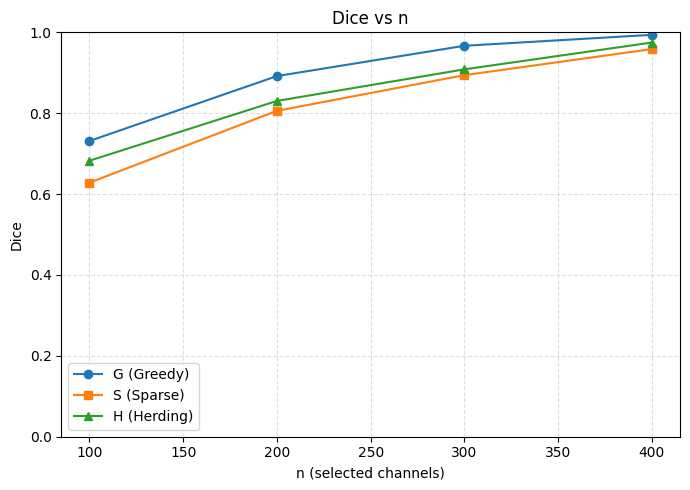

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\plot_H_vs_n.png


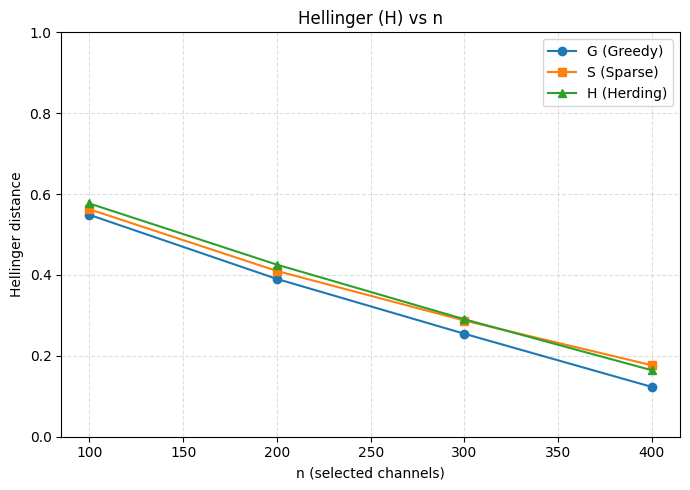

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\plot_Sim_vs_n.png


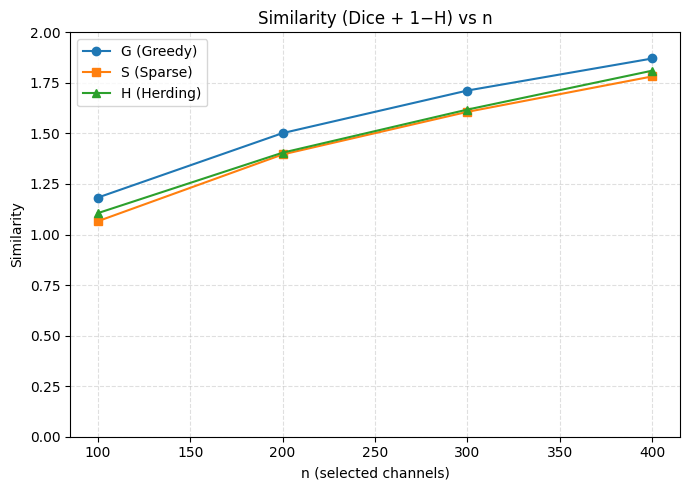

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\plot_Time_vs_n.png


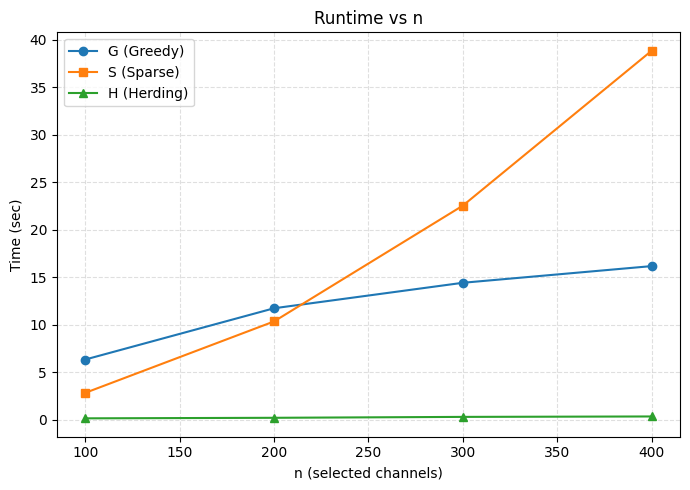

In [17]:
# -*- coding: utf-8 -*-
# Plot 4 separate line charts (no subplots): Dice, H, Sim, Time
# Each chart shows three strategies simultaneously: Greedy(G), Sparse(S), Herding(H)

import os
import numpy as np
import matplotlib.pyplot as plt

# ==== Path to your NPZ (update if needed) ====
NPZ_PATH = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\benchmark_GSH_102311_RH_full.npz"

# ==== PNG save option ====
SAVE_PNG = True  # False: just show; True: also save PNGs next to the NPZ

# ---------- Load ----------
data = np.load(NPZ_PATH, allow_pickle=True)

K = data["K"]                     # n values (e.g., [100,200,...])
G_dice, G_H, G_sim, G_time = data["G_dice"], data["G_H"], data["G_sim"], data["G_time"]
S_dice, S_H, S_sim, S_time = data["S_dice"], data["S_H"], data["S_sim"], data["S_time"]
H_dice, H_H, H_sim, H_time = data["H_dice"], data["H_H"], data["H_sim"], data["H_time"]

out_dir = os.path.dirname(NPZ_PATH)

def plot_metric(x, yG, yS, yH, title, ylabel, fname_stub, ylim=None):
    plt.figure(figsize=(7, 5))
    # three lines (no explicit colors)
    plt.plot(x, yG, marker="o", label="G (Greedy)")
    plt.plot(x, yS, marker="s", label="S (Sparse)")
    plt.plot(x, yH, marker="^", label="H (Herding)")
    plt.xlabel("n (selected channels)")
    plt.ylabel(ylabel)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    if SAVE_PNG:
        png_path = os.path.join(out_dir, f"{fname_stub}.png")
        plt.savefig(png_path, dpi=200, bbox_inches="tight")
        print("Saved:", png_path)
    plt.show()

# ---- Draw four separate figures ----
plot_metric(K, G_dice, S_dice, H_dice,
            title="Dice vs n",
            ylabel="Dice",
            fname_stub="plot_Dice_vs_n",
            ylim=(0, 1))

plot_metric(K, G_H, S_H, H_H,
            title="Hellinger (H) vs n",
            ylabel="Hellinger distance",
            fname_stub="plot_H_vs_n",
            ylim=(0, 1))

plot_metric(K, G_sim, S_sim, H_sim,
            title="Similarity (Dice + 1−H) vs n",
            ylabel="Similarity",
            fname_stub="plot_Sim_vs_n",
            ylim=(0, 2))  # Dice∈[0,1], (1−H)∈[0,1] → 합은 [0,2]

plot_metric(K, G_time, S_time, H_time,
            title="Runtime vs n",
            ylabel="Time (sec)",
            fname_stub="plot_Time_vs_n",
            ylim=None)


In [18]:
# -*- coding: utf-8 -*-
# Evaluate 3 strategies (G: Greedy, S: Sparse+NNLS, H: Kernel Herding)
# for n in {100, 400} across 8 pickle targets (102311, LH/RH × full/inner/lower/upper).
#
# Saves one NPZ with metrics arrays: Dice, H, Sim, Time for each strategy/case/n.

import os, time, pickle
import numpy as np

from sklearn.linear_model import lars_path
from electphos import prf_to_phos
from lossfunc import DC, hellinger_distance

# -----------------
# Inputs
# -----------------
PICKLES = [
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl",  "LH_full"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-inner.pkl", "LH_inner"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-lower.pkl", "LH_lower"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-upper.pkl", "LH_upper"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl",  "RH_full"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-inner.pkl", "RH_inner"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-lower.pkl", "RH_lower"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-upper.pkl", "RH_upper"),
]

# -----------------
# Config
# -----------------
WINDOWSIZE    = 1000
VIEW_ANGLE    = 90
DC_PERCENTILE = 50

# Downsample factor (1000 -> 100)
DS = 10

# n’s to test
K_TARGETS = [100, 400]

# Kernel herding bandwidth
SIGMA_MODE  = "median"  # "median" or numeric
SIGMA_SCALE = 1.0

# Similarity = Dice + (1 - H)  (Yield은 후보가 V1 매핑 집합이라는 전제에서 상수 취급)
A_DICE, B_1mH = 1.0, 1.0

EPS = 1e-12

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=EPS):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def downsample_avg(img, factor=DS):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0, "Image size must be divisible by factor"
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def single_map_raw(phosphenes_block):
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    return prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)

def dice_H_sim(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * dice + B_1mH * (1.0 - H)
    return float(dice), float(H), float(sim)

def rbf_kernel(X, Y=None, sigma=1.0):
    if Y is None:
        Y = X
    X = X.astype(np.float64); Y = Y.astype(np.float64)
    x2 = np.sum(X*X, axis=1, keepdims=True)
    y2 = np.sum(Y*Y, axis=1, keepdims=True).T
    XY = X @ Y.T
    dist2 = x2 + y2 - 2.0 * XY
    K = np.exp(-dist2 / (2.0 * (sigma**2) + EPS))
    return K

def median_sigma(X, max_n=400):
    n = X.shape[0]
    if n <= 2: return 1.0
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=min(n, max_n), replace=False)
    Z = X[idx]
    z2 = np.sum(Z*Z, axis=1, keepdims=True)
    D2 = z2 + z2.T - 2.0 * (Z @ Z.T)
    iu = np.triu_indices_from(D2, k=1)
    d = np.sqrt(np.clip(D2[iu], 0.0, None))
    med = np.median(d[d>0]) if np.any(d>0) else 1.0
    return float(med)

# Gram-based Projected-Gradient NNLS (full-res)
def gram_from_selected(get_raw_map, sel_ids, y_raw):
    K = len(sel_ids)
    G = np.zeros((K, K), dtype=np.float64)
    g = np.zeros((K,), dtype=np.float64)
    yv = y_raw.reshape(-1).astype(np.float64)
    Xcols = []
    for i, ch in enumerate(sel_ids):
        xi = get_raw_map(ch).reshape(-1).astype(np.float64)
        Xcols.append(xi)
        g[i] = float(xi @ yv)
    for i in range(K):
        xi = Xcols[i]
        for j in range(i, K):
            val = float(xi @ Xcols[j])
            G[i, j] = val
            G[j, i] = val
    return G, g

def projected_gradient_nnls(G, g, max_iters=2000, tol=1e-6, min_step=1e-8):
    K = G.shape[0]
    v = np.random.RandomState(0).randn(K); v /= (np.linalg.norm(v) + EPS)
    for _ in range(30):
        v = G @ v
        nv = np.linalg.norm(v)
        if nv < EPS: break
        v /= nv
    L = float(v @ (G @ v)) + EPS
    step = max(1.0 / L, min_step)
    w = np.zeros((K,), dtype=np.float64)
    prev_obj = np.inf
    for it in range(1, max_iters+1):
        grad = G @ w - g
        w -= step * grad
        w[w < 0] = 0.0
        obj = 0.5 * float(w @ (G @ w)) - float(g @ w)
        if it % 50 == 0 or it == 1:
            rel = abs(prev_obj - obj) / (abs(prev_obj) + EPS)
            if rel < tol: break
            prev_obj = obj
    return w.astype(np.float32)

# -----------------
# Storage alloc (case × n)
# -----------------
case_labels = [lab for _, lab in PICKLES]
num_cases = len(PICKLES)
K_vals = np.array(K_TARGETS, dtype=int)
num_K = len(K_vals)

G_dice = np.zeros((num_cases, num_K), dtype=np.float32)
G_H    = np.zeros((num_cases, num_K), dtype=np.float32)
G_sim  = np.zeros((num_cases, num_K), dtype=np.float32)
G_time = np.zeros((num_cases, num_K), dtype=np.float32)

S_dice = np.zeros((num_cases, num_K), dtype=np.float32)
S_H    = np.zeros((num_cases, num_K), dtype=np.float32)
S_sim  = np.zeros((num_cases, num_K), dtype=np.float32)
S_time = np.zeros((num_cases, num_K), dtype=np.float32)

H_dice = np.zeros((num_cases, num_K), dtype=np.float32)
H_H    = np.zeros((num_cases, num_K), dtype=np.float32)
H_sim  = np.zeros((num_cases, num_K), dtype=np.float32)
H_time = np.zeros((num_cases, num_K), dtype=np.float32)

K_used = np.zeros((num_cases, num_K), dtype=np.int32)  # 실제 사용된 n 저장
sigmas = np.zeros((num_cases,), dtype=np.float32)      # herding sigma 기록

# -----------------
# Main loop over 8 pickles
# -----------------
for ci, (pkl_path, label) in enumerate(PICKLES):
    with open(pkl_path, "rb") as f:
        (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
         contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
         phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

    print(f"\n=== Case {ci+1}/{num_cases}: {label} ===")
    # Build candidates & common features
    candidate_idx = []
    ds_raw_cols = []   # (F_ds x n_ch)
    X_pdf_rows  = []   # (n_ch x F_ds)
    target_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)

    for i in range(phosphenes_V1.shape[0]):
        pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
        if pm_raw.sum() <= 0:
            continue
        target_pm_raw += pm_raw
        v_ds_raw = downsample_avg(pm_raw, DS).reshape(-1).astype(np.float32)
        v_ds_pdf = normalize_pdf(v_ds_raw.copy())
        ds_raw_cols.append(v_ds_raw)
        X_pdf_rows.append(v_ds_pdf)
        candidate_idx.append(i)

    candidate_idx = np.array(candidate_idx, dtype=int)
    if candidate_idx.size == 0:
        print("  No valid candidates, skipping.")
        continue

    X_ds = np.stack(ds_raw_cols, axis=1)    # (F_ds x n_ch)
    X_pdf = np.stack(X_pdf_rows, axis=0)    # (n_ch x F_ds)
    col_norms = np.linalg.norm(X_ds, axis=0) + EPS
    n_ch = candidate_idx.size
    print(f"  Candidates: {n_ch}")

    target_pdf    = normalize_pdf(target_pm_raw)
    target_ds_pdf = normalize_pdf(downsample_avg(target_pm_raw, DS).reshape(-1))
    BIN_THRESH    = np.percentile(target_pdf, DC_PERCENTILE)

    # Precompute kernels for Herding
    if SIGMA_MODE == "median":
        sigma = median_sigma(X_pdf) * float(SIGMA_SCALE)
    else:
        sigma = float(SIGMA_MODE)
    sigmas[ci] = sigma
    K_xx = rbf_kernel(X_pdf, None, sigma=sigma)                              # (n_ch x n_ch)
    K_xy = rbf_kernel(X_pdf, target_ds_pdf[None, :], sigma=sigma).reshape(-1)  # (n_ch,)

    # Precompute LARS path for Sparse
    Xn = X_ds / col_norms
    alphas, active, coefs = lars_path(Xn, target_ds_pdf, method='lasso', positive=True, verbose=False)
    nnz_counts = (np.abs(coefs) > 1e-12).sum(axis=0)

    # On-demand raw map (cache)
    _raw_cache = {}
    def get_raw_map(ch):
        if ch not in _raw_cache:
            _raw_cache[ch] = single_map_raw(phosphenes_V1[ch:ch+1, :])
        return _raw_cache[ch]

    h_ds, w_ds = WINDOWSIZE//DS, WINDOWSIZE//DS

    # ---- iterate over K targets (100, 400) ----
    for ki, K in enumerate(K_TARGETS):
        K_act = min(K, n_ch)  # ensure not exceeding candidates
        K_used[ci, ki] = K_act
        print(f"  - n={K} (use {K_act})")

        # (H) Kernel Herding
        t0 = time.time()
        selected_mask = np.zeros(n_ch, dtype=bool)
        sum_Ki = np.zeros(n_ch, dtype=np.float64)
        selected_local = []
        for t in range(1, K_act+1):
            score = K_xy - (sum_Ki / max(1, t))
            score[selected_mask] = -np.inf
            i_star = int(np.argmax(score))
            selected_local.append(i_star)
            selected_mask[i_star] = True
            sum_Ki += K_xx[:, i_star]
        sel_H = candidate_idx[np.array(selected_local, dtype=int)]
        selected_pm_raw = np.zeros_like(target_pm_raw)
        for ch in sel_H:
            selected_pm_raw += get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)
        d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
        tH = time.time() - t0
        H_dice[ci, ki] = d; H_H[ci, ki] = h; H_sim[ci, ki] = s; H_time[ci, ki] = tH
        print(f"    [H] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tH:.2f}s")

        # (S) Sparse + full-res Gram-NNLS
        t0 = time.time()
        if np.any(nnz_counts == K_act):
            j = int(np.argmax(nnz_counts == K_act))
        else:
            idx_le = np.where(nnz_counts <= K_act)[0]
            j = int(idx_le[-1]) if idx_le.size > 0 else int(np.argmax(nnz_counts))
        support = np.where(coefs[:, j] > 1e-12)[0].tolist()
        if len(support) < K_act:
            resid = target_ds_pdf - (Xn @ coefs[:, j])
            corr = Xn.T @ resid
            add_order = np.argsort(-corr)
            for q in add_order:
                if q not in support:
                    support.append(int(q))
                    if len(support) == K_act: break
        if len(support) > K_act:
            w_abs = np.abs(coefs[support, j])
            keep = np.argsort(-w_abs)[:K_act]
            support = [support[i] for i in keep]
        sel_S = candidate_idx[np.array(support, dtype=int)].tolist()
        Gm, gv = gram_from_selected(get_raw_map, sel_S, target_pm_raw)
        w = projected_gradient_nnls(Gm, gv, max_iters=2000, tol=1e-6, min_step=1e-8)
        selected_pm_raw = np.zeros_like(target_pm_raw)
        for ch, wi in zip(sel_S, w):
            if wi <= 0: continue
            selected_pm_raw += wi * get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)
        d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
        tS = time.time() - t0
        S_dice[ci, ki] = d; S_H[ci, ki] = h; S_sim[ci, ki] = s; S_time[ci, ki] = tS
        print(f"    [S] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tS:.2f}s")

        # (G) Greedy in DS space (evaluate full-res)
        t0 = time.time()
        remaining = set(range(n_ch))
        selected_local = []
        current_ds_raw = np.zeros((h_ds*w_ds,), dtype=np.float32)
        # precompute DS 2D target for DC proxy
        target_ds_2d = target_ds_pdf.reshape(h_ds, w_ds)
        bin_th_ds = np.percentile(target_ds_2d, DC_PERCENTILE)
        for step in range(1, K_act+1):
            best_score = -1e9; best_i = None
            for i in remaining:
                cand_ds_raw = current_ds_raw + X_ds[:, i]
                cand_ds_pdf = normalize_pdf(cand_ds_raw)
                # DS proxy metrics
                cand_2d = cand_ds_pdf.reshape(h_ds, w_ds)
                dice_ds, _, _ = DC(target_ds_2d, cand_2d, bin_th_ds)
                H_ds = float(hellinger_distance(cand_ds_pdf, target_ds_pdf))
                sim_ds = A_DICE * dice_ds + B_1mH * (1.0 - H_ds)
                if sim_ds > best_score:
                    best_score = sim_ds; best_i = i
            selected_local.append(best_i)
            remaining.remove(best_i)
            current_ds_raw += X_ds[:, best_i]
        sel_G = candidate_idx[np.array(selected_local, dtype=int)]
        selected_pm_raw = np.zeros_like(target_pm_raw)
        for ch in sel_G:
            selected_pm_raw += get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)
        d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
        tG = time.time() - t0
        G_dice[ci, ki] = d; G_H[ci, ki] = h; G_sim[ci, ki] = s; G_time[ci, ki] = tG
        print(f"    [G] Dice={d:.4f} H={h:.4f} Sim={s:.4f}  time={tG:.2f}s")

# -----------------
# Save NPZ
# -----------------
out_dir = os.path.dirname(PICKLES[0][0])
out_npz = os.path.join(out_dir, "benchmark_GSH_102311_LH_RH_alltargets_n100_400.npz")
np.savez(out_npz,
         cases=np.array(case_labels, dtype=object),
         K_targets=np.array(K_TARGETS, dtype=int),
         K_used=K_used,
         # Greedy
         G_dice=G_dice, G_H=G_H, G_sim=G_sim, G_time=G_time,
         # Sparse
         S_dice=S_dice, S_H=S_H, S_sim=S_sim, S_time=S_time,
         # Herding
         H_dice=H_dice, H_H=H_H, H_sim=H_sim, H_time=H_time,
         # meta
         ds_factor=np.array([DS], dtype=np.int32),
         sigma_per_case=sigmas)
print("Saved:", out_npz)



=== Case 1/8: LH_full ===
  Candidates: 502
  - n=100 (use 100)
    [H] Dice=0.8054 H=0.4722 Sim=1.3333  time=0.14s
    [S] Dice=0.7712 H=0.4695 Sim=1.3017  time=2.89s
    [G] Dice=0.8441 H=0.4578 Sim=1.3862  time=3.69s
  - n=400 (use 400)
    [H] Dice=0.9899 H=0.1524 Sim=1.8375  time=0.46s
    [S] Dice=0.9849 H=0.1516 Sim=1.8332  time=38.03s
    [G] Dice=0.9975 H=0.1089 Sim=1.8886  time=9.37s

=== Case 2/8: LH_inner ===
  Candidates: 543
  - n=100 (use 100)
    [H] Dice=0.5531 H=0.6517 Sim=0.9013  time=0.13s
    [S] Dice=0.5410 H=0.6237 Sim=0.9173  time=2.74s
    [G] Dice=0.5947 H=0.6451 Sim=0.9496  time=4.09s
  - n=400 (use 400)
    [H] Dice=0.9423 H=0.2826 Sim=1.6596  time=0.45s
    [S] Dice=0.9537 H=0.2817 Sim=1.6720  time=38.68s
    [G] Dice=0.9708 H=0.2304 Sim=1.7404  time=11.75s

=== Case 3/8: LH_lower ===
  Candidates: 349
  - n=100 (use 100)
    [H] Dice=0.7486 H=0.4998 Sim=1.2488  time=0.15s
    [S] Dice=0.6923 H=0.5094 Sim=1.1829  time=2.94s
    [G] Dice=0.8056 H=0.4845 Sim

[WARN] case=LH_lower: requested n=400, used n=349
[WARN] case=LH_upper: requested n=400, used n=254
[WARN] case=RH_lower: requested n=400, used n=248
[WARN] case=RH_upper: requested n=400, used n=276
Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_Sim_n100.png


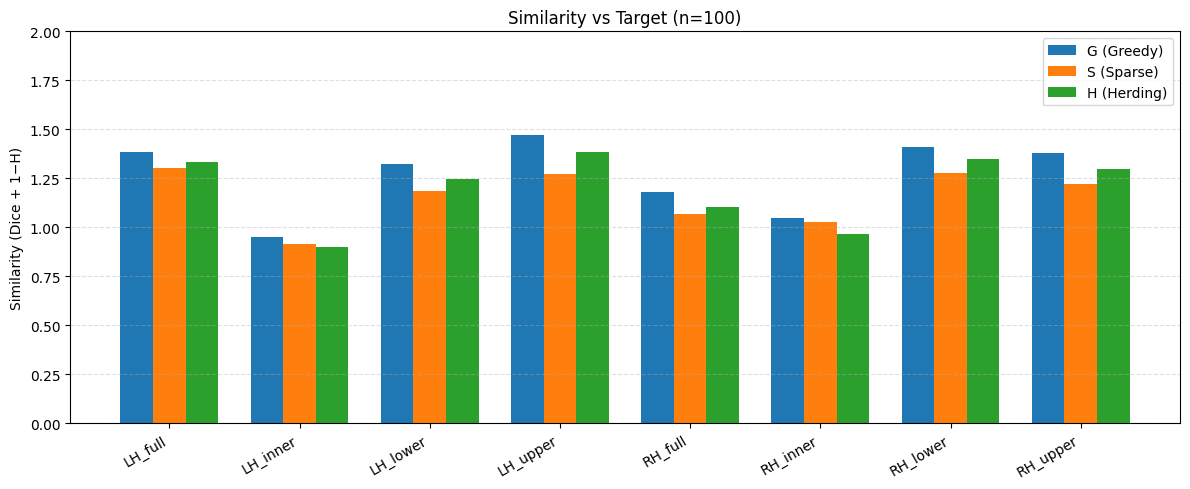

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_Time_n100.png


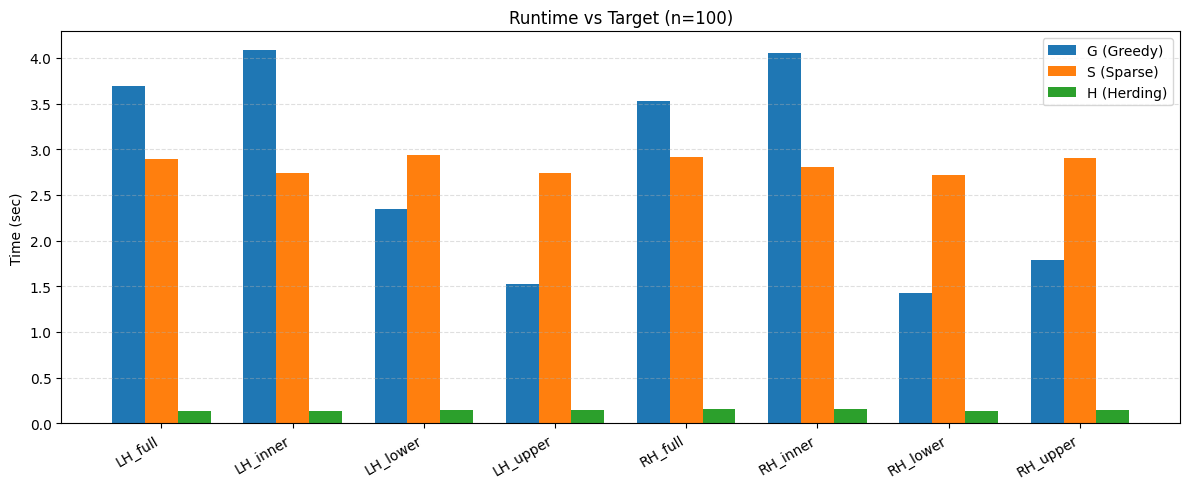

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_Sim_n400.png


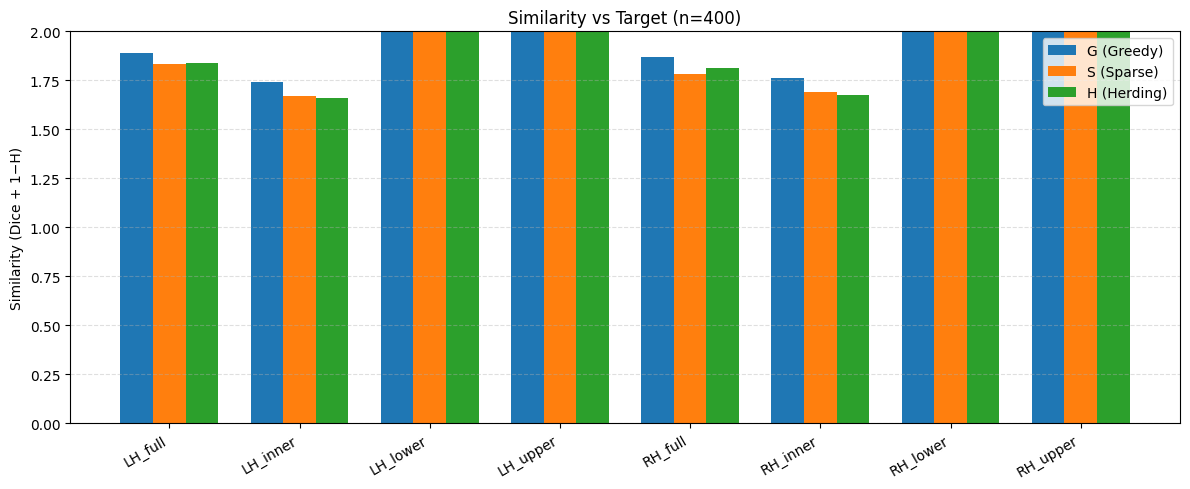

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_Time_n400.png


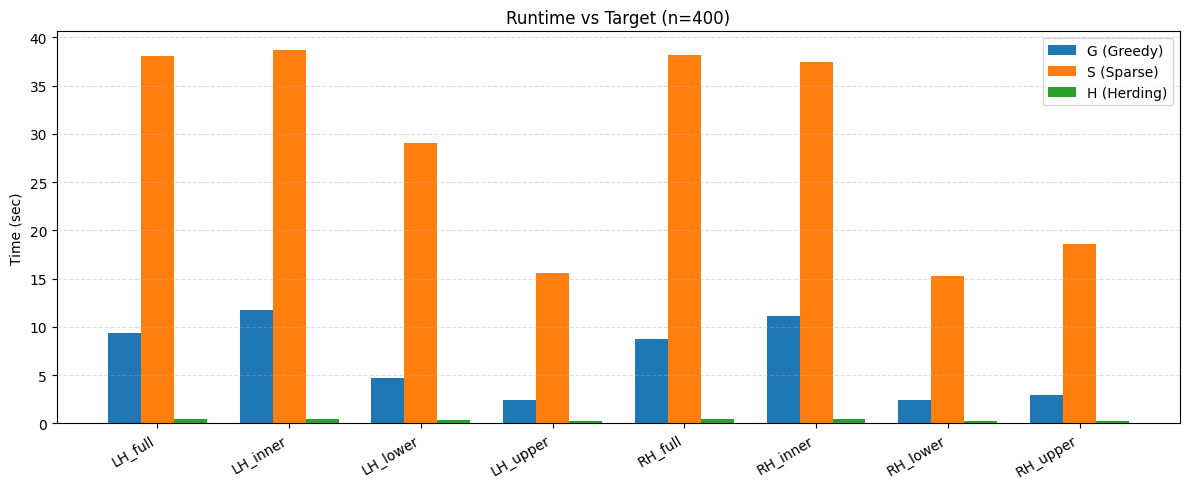

In [19]:
# -*- coding: utf-8 -*-
# Grouped bar plots for n=100 and n=400 (Similarity & Runtime) across 8 target maps
# Data source: benchmark_GSH_102311_LH_RH_alltargets_n100_400.npz

import os
import numpy as np
import matplotlib.pyplot as plt

# === Path to your NPZ ===
NPZ_PATH = r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\benchmark_GSH_102311_LH_RH_alltargets_n100_400.npz"

# === Save PNGs? ===
SAVE_PNG = True

# ---------- Load ----------
data = np.load(NPZ_PATH, allow_pickle=True)

cases     = data["cases"]               # shape: (num_cases,)
K_targets = data["K_targets"]           # [100, 400]
K_used    = data["K_used"]              # (num_cases, 2)

G_sim, S_sim, H_sim = data["G_sim"], data["S_sim"], data["H_sim"]   # (num_cases, 2)
G_time, S_time, H_time = data["G_time"], data["S_time"], data["H_time"]

# helper: get index of a target n (e.g., 100 or 400)
def idx_of_n(n):
    idxs = np.where(K_targets == n)[0]
    if idxs.size == 0:
        raise ValueError(f"Requested n={n} not found in K_targets={K_targets.tolist()}")
    return int(idxs[0])

idx100 = idx_of_n(100)
idx400 = idx_of_n(400)

# Warn if some cases couldn't reach the requested n (because of limited candidates)
for ci, name in enumerate(cases):
    if K_used[ci, idx100] != 100:
        print(f"[WARN] case={name}: requested n=100, used n={K_used[ci, idx100]}")
    if K_used[ci, idx400] != 400:
        print(f"[WARN] case={name}: requested n=400, used n={K_used[ci, idx400]}")

# ---------- Plot helper ----------
def plot_grouped_bars(x_labels, yG, yS, yH, title, ylabel, fname_stub, ylim=None):
    num = len(x_labels)
    x = np.arange(num)
    width = 0.25

    plt.figure(figsize=(12, 5))
    plt.bar(x - width, yG, width, label="G (Greedy)")
    plt.bar(x,          yS, width, label="S (Sparse)")
    plt.bar(x + width,  yH, width, label="H (Herding)")

    plt.xticks(x, x_labels, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()

    if SAVE_PNG:
        out_dir = os.path.dirname(NPZ_PATH)
        png_path = os.path.join(out_dir, f"{fname_stub}.png")
        plt.savefig(png_path, dpi=200, bbox_inches="tight")
        print("Saved:", png_path)

    plt.show()

# ---------- n=100: Similarity ----------
plot_grouped_bars(
    x_labels=cases,
    yG=G_sim[:, idx100], yS=S_sim[:, idx100], yH=H_sim[:, idx100],
    title="Similarity vs Target (n=100)",
    ylabel="Similarity (Dice + 1−H)",
    fname_stub="groupbar_Sim_n100",
    ylim=(0, 2)  # Dice∈[0,1], (1−H)∈[0,1]
)

# ---------- n=100: Runtime ----------
plot_grouped_bars(
    x_labels=cases,
    yG=G_time[:, idx100], yS=S_time[:, idx100], yH=H_time[:, idx100],
    title="Runtime vs Target (n=100)",
    ylabel="Time (sec)",
    fname_stub="groupbar_Time_n100",
    ylim=None
)

# ---------- n=400: Similarity ----------
plot_grouped_bars(
    x_labels=cases,
    yG=G_sim[:, idx400], yS=S_sim[:, idx400], yH=H_sim[:, idx400],
    title="Similarity vs Target (n=400)",
    ylabel="Similarity (Dice + 1−H)",
    fname_stub="groupbar_Sim_n400",
    ylim=(0, 2)
)

# ---------- n=400: Runtime ----------
plot_grouped_bars(
    x_labels=cases,
    yG=G_time[:, idx400], yS=S_time[:, idx400], yH=H_time[:, idx400],
    title="Runtime vs Target (n=400)",
    ylabel="Time (sec)",
    fname_stub="groupbar_Time_n400",
    ylim=None
)



=== Case 1/8: LH_full ===
  Candidates: 502
  - n=100 (use 100)
    [H] Dice=0.4626 H=0.7928 Sim=0.6698 time=0.14s
    [S] Dice=0.4696 H=0.7661 Sim=0.7034 time=2.96s
    [G] Dice=0.5614 H=0.7477 Sim=0.8137 time=3.87s
  - n=400 (use 400)
    [H] Dice=0.6485 H=0.6964 Sim=0.9521 time=0.44s
    [S] Dice=0.6877 H=0.6635 Sim=1.0242 time=37.84s
    [G] Dice=0.6961 H=0.6590 Sim=1.0371 time=10.21s

=== Case 2/8: LH_inner ===
  Candidates: 543
  - n=100 (use 100)
    [H] Dice=0.2394 H=0.8787 Sim=0.3608 time=0.14s
    [S] Dice=0.1688 H=0.8754 Sim=0.2935 time=2.91s
    [G] Dice=0.2527 H=0.8670 Sim=0.3857 time=4.21s
  - n=400 (use 400)
    [H] Dice=0.4885 H=0.7732 Sim=0.7153 time=0.43s
    [S] Dice=0.4670 H=0.7686 Sim=0.6984 time=39.38s
    [G] Dice=0.5158 H=0.7562 Sim=0.7596 time=11.90s

=== Case 3/8: LH_lower ===
  Candidates: 349
  - n=100 (use 100)
    [H] Dice=0.5989 H=0.7560 Sim=0.8428 time=0.14s
    [S] Dice=0.6444 H=0.7082 Sim=0.9362 time=2.78s
    [G] Dice=0.7310 H=0.6870 Sim=1.0440 time=

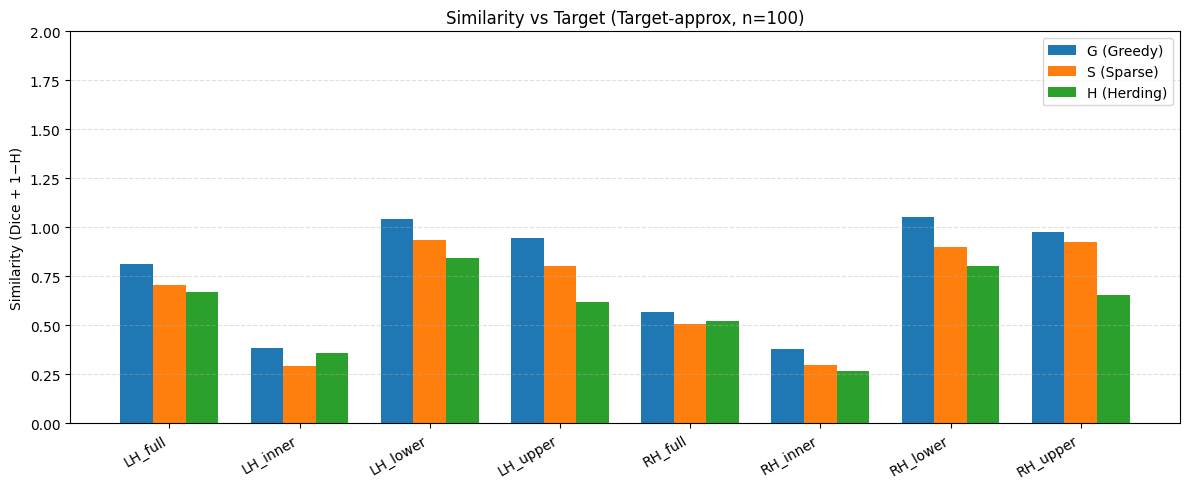

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_TargetApprox_Time_n100.png


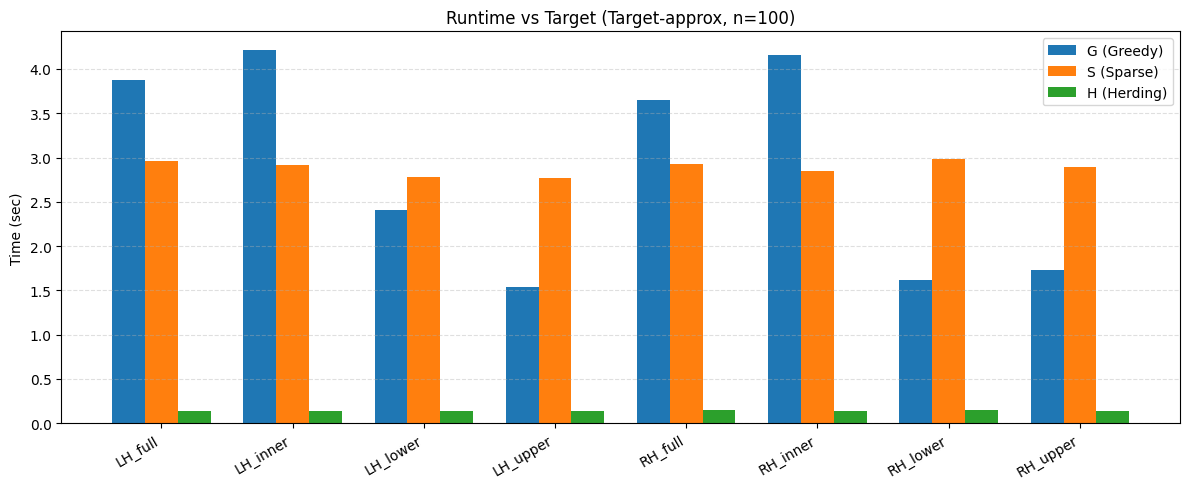

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_TargetApprox_Sim_n400.png


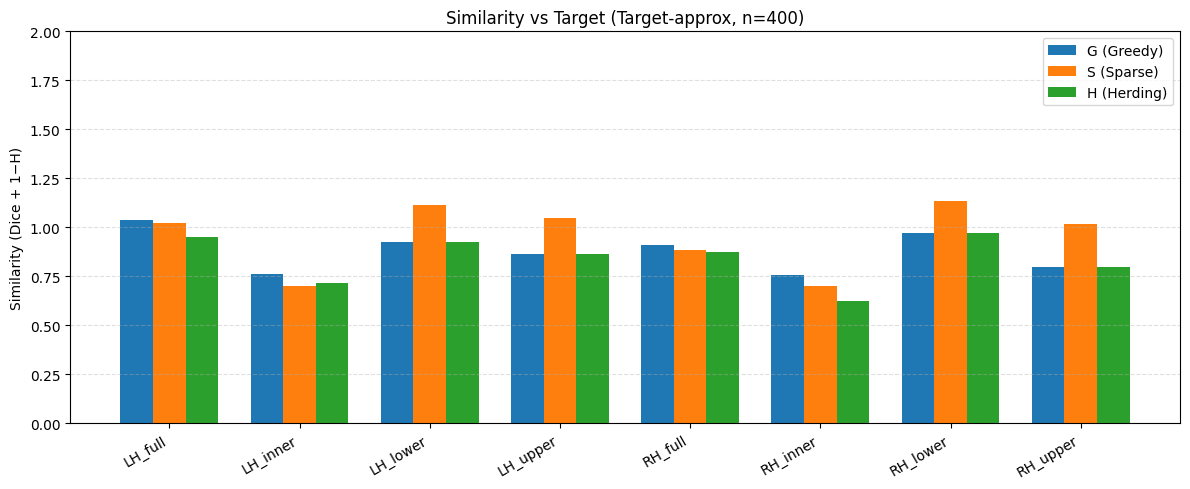

Saved: C:\Users\user\YongtaeC\vimplant0812\data\output\102311\groupbar_TargetApprox_Time_n400.png


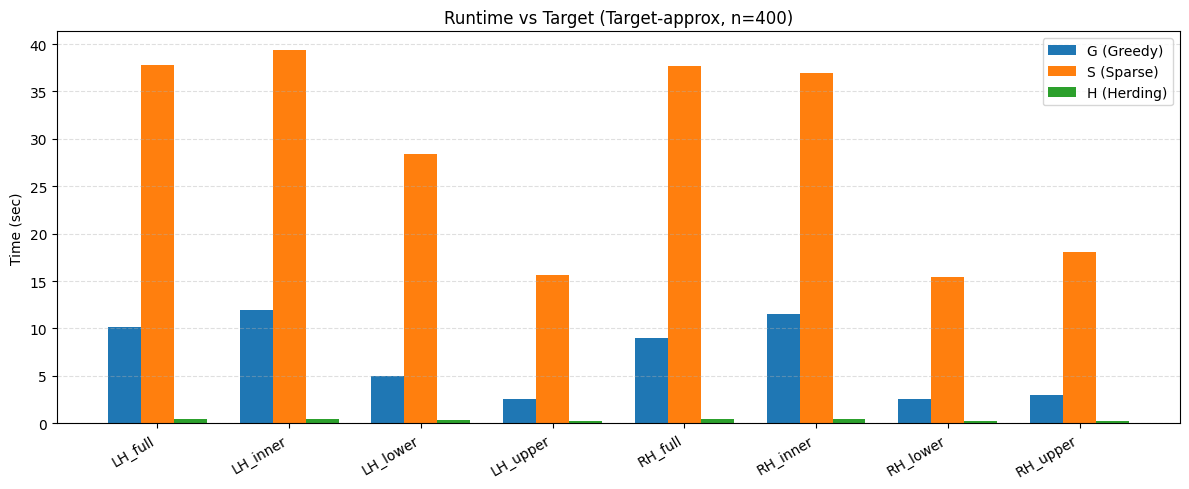

In [20]:
# -*- coding: utf-8 -*-
# Target-approximation benchmark & grouped bar plots (n=100, 400) for 8 target maps
# 기준 타깃: visualsectors.* 로 생성한 T (full/inner/lower/upper)
# 전략: G(그리디), S(희소회귀+풀해상도 NNLS), H(커널허딩/MMD)
#
# 1) 8개 pkl 각각에서 후보(phosphenes_V1) 구성
# 2) target T를 visualsectors로 생성 → 평가 기준으로 사용
# 3) n∈{100,400}에 대해 각 전략의 (Dice, H, Sim=Dice+(1−H), 시간) 계산
# 4) NPZ 저장 → 그룹 막대 그래프 4개 생성/저장

import os, time, pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lars_path
from electphos import prf_to_phos
from lossfunc import DC, hellinger_distance
import visualsectors as gvs  # 타깃 맵 생성

# -----------------
# Inputs (8 pickles)
# -----------------
PICKLES = [
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl",  "LH_full"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-inner.pkl", "LH_inner"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-lower.pkl", "LH_lower"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_LH_V1_n1000_1x10_dice-yield-HD_0.05_targ-upper.pkl", "LH_upper"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-full.pkl",  "RH_full"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-inner.pkl", "RH_inner"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-lower.pkl", "RH_lower"),
    (r"C:\Users\user\YongtaeC\vimplant0812\data\output\102311\102311_RH_V1_n1000_1x10_dice-yield-HD_0.05_targ-upper.pkl", "RH_upper"),
]

# -----------------
# Config
# -----------------
WINDOWSIZE    = 1000
VIEW_ANGLE    = 90
DC_PERCENTILE = 50

# Downsample (1000->100)
DS = 10

# n’s
K_TARGETS = [100, 400]

# Herding kernel bandwidth
SIGMA_MODE  = "median"  # "median" or numeric(float)
SIGMA_SCALE = 1.0

# Similarity = Dice + (1 - H)  (Yield은 V1 후보 내 상수 취급)
A_DICE, B_1mH = 1.0, 1.0

SAVE_PNG = True  # 플롯 PNG 저장

EPS = 1e-12

# -----------------
# Helpers
# -----------------
def normalize_pdf(x, eps=EPS):
    x = np.clip(x, 0, None).astype(np.float32)
    s = float(x.sum())
    return x / (s + eps)

def downsample_avg(img, factor=DS):
    H, W = img.shape
    assert H % factor == 0 and W % factor == 0
    h, w = H // factor, W // factor
    return img.reshape(h, factor, w, factor).mean(axis=(1, 3))

def single_map_raw(phosphenes_block):
    pm = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
    if phosphenes_block.size == 0:
        return pm
    return prf_to_phos(pm, phosphenes_block, view_angle=VIEW_ANGLE, phSizeScale=1)

def dice_H_sim(target_pdf, cand_pdf, bin_thresh):
    dice, _, _ = DC(target_pdf, cand_pdf, bin_thresh)
    H = float(hellinger_distance(cand_pdf.flatten(), target_pdf.flatten()))
    sim = A_DICE * float(dice) + B_1mH * (1.0 - H)
    return float(dice), float(H), float(sim)

def rbf_kernel(X, Y=None, sigma=1.0):
    if Y is None:
        Y = X
    X = X.astype(np.float64); Y = Y.astype(np.float64)
    x2 = np.sum(X*X, axis=1, keepdims=True)
    y2 = np.sum(Y*Y, axis=1, keepdims=True).T
    XY = X @ Y.T
    dist2 = x2 + y2 - 2.0 * XY
    return np.exp(-dist2 / (2.0 * (sigma**2) + EPS))

def median_sigma(X, max_n=400):
    n = X.shape[0]
    if n <= 2: return 1.0
    rng = np.random.default_rng(0)
    idx = rng.choice(n, size=min(n, max_n), replace=False)
    Z = X[idx]
    z2 = np.sum(Z*Z, axis=1, keepdims=True)
    D2 = z2 + z2.T - 2.0 * (Z @ Z.T)
    iu = np.triu_indices_from(D2, k=1)
    d = np.sqrt(np.clip(D2[iu], 0.0, None))
    med = np.median(d[d>0]) if np.any(d>0) else 1.0
    return float(med)

# 풀해상도 Gram-NNLS
def gram_from_selected(get_raw_map, sel_ids, y_raw):
    K = len(sel_ids)
    G = np.zeros((K, K), dtype=np.float64)
    g = np.zeros((K,), dtype=np.float64)
    yv = y_raw.reshape(-1).astype(np.float64)
    Xcols = []
    for i, ch in enumerate(sel_ids):
        xi = get_raw_map(ch).reshape(-1).astype(np.float64)
        Xcols.append(xi)
        g[i] = float(xi @ yv)
    for i in range(K):
        xi = Xcols[i]
        for j in range(i, K):
            val = float(xi @ Xcols[j])
            G[i, j] = val; G[j, i] = val
    return G, g

def projected_gradient_nnls(G, g, max_iters=2000, tol=1e-6, min_step=1e-8):
    K = G.shape[0]
    v = np.random.RandomState(0).randn(K); v /= (np.linalg.norm(v) + EPS)
    for _ in range(30):
        v = G @ v; nv = np.linalg.norm(v)
        if nv < EPS: break
        v /= nv
    L = float(v @ (G @ v)) + EPS
    step = max(1.0 / L, min_step)
    w = np.zeros((K,), dtype=np.float64)
    prev_obj = np.inf
    for it in range(1, max_iters+1):
        grad = G @ w - g
        w -= step * grad
        w[w < 0] = 0.0
        obj = 0.5 * float(w @ (G @ w)) - float(g @ w)
        if it % 50 == 0 or it == 1:
            rel = abs(prev_obj - obj) / (abs(prev_obj) + EPS)
            if rel < tol: break
            prev_obj = obj
    return w.astype(np.float32)

# visualsectors 타깃 생성
def make_target_by_label(label):
    # label: "..._full|inner|lower|upper"
    kind = label.split("_")[-1].lower()
    if kind == "upper":
        T = gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False)
    elif kind == "lower":
        T = gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False)
    elif kind == "inner":
        T = gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False)
    elif kind == "full":
        T = gvs.complete_gauss(windowsize=WINDOWSIZE, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)
    else:
        raise ValueError(f"Unknown target kind in label: {label}")
    T = T.astype(np.float32)
    T /= (T.max() + EPS)
    T = normalize_pdf(T)
    return T

# -----------------
# Storage (case × n)
# -----------------
case_labels = [lab for _, lab in PICKLES]
num_cases = len(PICKLES)
K_vals = np.array(K_TARGETS, dtype=int)
num_K = len(K_vals)

G_sim = np.zeros((num_cases, num_K), dtype=np.float32)
S_sim = np.zeros((num_cases, num_K), dtype=np.float32)
H_sim = np.zeros((num_cases, num_K), dtype=np.float32)

G_time = np.zeros((num_cases, num_K), dtype=np.float32)
S_time = np.zeros((num_cases, num_K), dtype=np.float32)
H_time = np.zeros((num_cases, num_K), dtype=np.float32)

G_dice = np.zeros((num_cases, num_K), dtype=np.float32)
S_dice = np.zeros((num_cases, num_K), dtype=np.float32)
H_dice = np.zeros((num_cases, num_K), dtype=np.float32)

G_H = np.zeros((num_cases, num_K), dtype=np.float32)
S_H = np.zeros((num_cases, num_K), dtype=np.float32)
H_H = np.zeros((num_cases, num_K), dtype=np.float32)

K_used = np.zeros((num_cases, num_K), dtype=np.int32)
sigmas = np.zeros((num_cases,), dtype=np.float32)

# -----------------
# Main: per case
# -----------------
for ci, (pkl_path, label) in enumerate(PICKLES):
    with open(pkl_path, "rb") as f:
        (res, grid_valid, dice_best, hell_d_best, grid_yield_best,
         contacts_xyz_moved, good_coords, good_coords_V1, good_coords_V2, good_coords_V3,
         phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3) = pickle.load(f)

    print(f"\n=== Case {ci+1}/{num_cases}: {label} ===")
    # 후보 & 공통 전처리
    candidate_idx = []
    X_ds_cols = []   # (F_ds x n_ch)
    X_pdf_rows = []  # (n_ch x F_ds)
    h_ds, w_ds = WINDOWSIZE//DS, WINDOWSIZE//DS
    F_ds = h_ds * w_ds

    for i in range(phosphenes_V1.shape[0]):
        pm_raw = single_map_raw(phosphenes_V1[i:i+1, :])
        if pm_raw.sum() <= 0:
            continue
        v_ds_raw = downsample_avg(pm_raw, DS).reshape(-1).astype(np.float32)
        v_ds_pdf = normalize_pdf(v_ds_raw.copy())
        X_ds_cols.append(v_ds_raw)
        X_pdf_rows.append(v_ds_pdf)
        candidate_idx.append(i)

    candidate_idx = np.array(candidate_idx, dtype=int)
    if candidate_idx.size == 0:
        print("  No valid candidates; skip.")
        continue

    X_ds  = np.stack(X_ds_cols, axis=1)   # (F_ds x n_ch), DS raw
    X_pdf = np.stack(X_pdf_rows, axis=0)  # (n_ch x F_ds), DS pdf
    col_norms = np.linalg.norm(X_ds, axis=0) + EPS
    n_ch = candidate_idx.size
    print(f"  Candidates: {n_ch}")

    # 타깃 맵 (visualsectors)
    target_pdf = make_target_by_label(label)
    BIN_THRESH = np.percentile(target_pdf, DC_PERCENTILE)
    target_ds_pdf = normalize_pdf(downsample_avg(target_pdf, DS).reshape(-1))
    target_ds_2d  = target_ds_pdf.reshape(h_ds, w_ds)
    bin_th_ds = np.percentile(target_ds_2d, DC_PERCENTILE)

    # 커널 준비(H)
    if SIGMA_MODE == "median":
        sigma = median_sigma(X_pdf) * float(SIGMA_SCALE)
    else:
        sigma = float(SIGMA_MODE)
    sigmas[ci] = sigma
    K_xx = rbf_kernel(X_pdf, None, sigma=sigma)                              # (n_ch x n_ch)
    K_xy = rbf_kernel(X_pdf, target_ds_pdf[None, :], sigma=sigma).reshape(-1)  # (n_ch,)

    # LARS 경로(S)
    Xn = X_ds / col_norms
    alphas, active, coefs = lars_path(Xn, target_ds_pdf, method='lasso', positive=True, verbose=False)
    nnz_counts = (np.abs(coefs) > 1e-12).sum(axis=0)

    # full-res raw map provider (필요시 캐시)
    _raw_cache = {}
    def get_raw_map(ch):
        if ch not in _raw_cache:
            _raw_cache[ch] = single_map_raw(phosphenes_V1[ch:ch+1, :])
        return _raw_cache[ch]

    # per n
    for ki, K in enumerate(K_TARGETS):
        K_act = min(K, n_ch)
        K_used[ci, ki] = K_act
        print(f"  - n={K} (use {K_act})")

        # (H) Kernel Herding
        t0 = time.time()
        selected_mask = np.zeros(n_ch, dtype=bool)
        sum_Ki = np.zeros(n_ch, dtype=np.float64)
        selected_local = []
        for t in range(1, K_act+1):
            score = K_xy - (sum_Ki / max(1, t))
            score[selected_mask] = -np.inf
            i_star = int(np.argmax(score))
            selected_local.append(i_star)
            selected_mask[i_star] = True
            sum_Ki += K_xx[:, i_star]
        sel_H = candidate_idx[np.array(selected_local, dtype=int)]
        # full-res 합성 (균등 가중)
        selected_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
        for ch in sel_H:
            selected_pm_raw += get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)
        d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
        tH = time.time() - t0
        H_dice[ci, ki] = d; H_H[ci, ki] = h; H_sim[ci, ki] = s; H_time[ci, ki] = tH
        print(f"    [H] Dice={d:.4f} H={h:.4f} Sim={s:.4f} time={tH:.2f}s")

        # (S) Sparse: LARS support → full-res Gram-NNLS 리핏
        t0 = time.time()
        if np.any(nnz_counts == K_act):
            j = int(np.argmax(nnz_counts == K_act))
        else:
            idx_le = np.where(nnz_counts <= K_act)[0]
            j = int(idx_le[-1]) if idx_le.size>0 else int(np.argmax(nnz_counts))
        support = np.where(coefs[:, j] > 1e-12)[0].tolist()
        if len(support) < K_act:
            resid = target_ds_pdf - (Xn @ coefs[:, j])
            corr = Xn.T @ resid
            add_order = np.argsort(-corr)
            for q in add_order:
                if q not in support:
                    support.append(int(q))
                    if len(support) == K_act: break
        if len(support) > K_act:
            w_abs = np.abs(coefs[support, j])
            keep = np.argsort(-w_abs)[:K_act]
            support = [support[i] for i in keep]
        sel_S = candidate_idx[np.array(support, dtype=int)].tolist()
        # full-res NNLS
        # 타깃은 target_pdf이나 NNLS는 L2 기준이므로 y_raw 대신 target_raw가 필요 → PDF를 raw로 재스케일해도 상수배 차이뿐이므로 PDF 자체를 쓰고 Gram/교차항도 PDF 기준으로 생성해도 가중치 스케일만 달라짐(정규화 후 평가엔 무관)
        y_raw = target_pdf  # PDF를 "raw"로 간주
        Gm, gv = gram_from_selected(get_raw_map, sel_S, y_raw)
        w = projected_gradient_nnls(Gm, gv, max_iters=2000, tol=1e-6, min_step=1e-8)
        selected_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
        for ch, wi in zip(sel_S, w):
            if wi <= 0: continue
            selected_pm_raw += wi * get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)
        d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
        tS = time.time() - t0
        S_dice[ci, ki] = d; S_H[ci, ki] = h; S_sim[ci, ki] = s; S_time[ci, ki] = tS
        print(f"    [S] Dice={d:.4f} H={h:.4f} Sim={s:.4f} time={tS:.2f}s")

        # (G) Greedy (DS 공간에서 선택, full-res 평가)
        t0 = time.time()
        remaining = set(range(n_ch))
        selected_local = []
        current_ds_raw = np.zeros((F_ds,), dtype=np.float32)
        for step in range(1, K_act+1):
            best_score = -1e9; best_i = None
            for i in remaining:
                cand_ds_raw = current_ds_raw + X_ds[:, i]
                cand_ds_pdf = normalize_pdf(cand_ds_raw)
                cand_2d = cand_ds_pdf.reshape(h_ds, w_ds)
                dice_ds, _, _ = DC(target_ds_2d, cand_2d, bin_th_ds)
                H_ds = float(hellinger_distance(cand_ds_pdf, target_ds_pdf))
                sim_ds = A_DICE * dice_ds + B_1mH * (1.0 - H_ds)
                if sim_ds > best_score:
                    best_score = sim_ds; best_i = i
            selected_local.append(best_i)
            remaining.remove(best_i)
            current_ds_raw += X_ds[:, best_i]
        sel_G = candidate_idx[np.array(selected_local, dtype=int)]
        selected_pm_raw = np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32)
        for ch in sel_G:
            selected_pm_raw += get_raw_map(ch)
        selected_pdf = normalize_pdf(selected_pm_raw)
        d, h, s = dice_H_sim(target_pdf, selected_pdf, BIN_THRESH)
        tG = time.time() - t0
        G_dice[ci, ki] = d; G_H[ci, ki] = h; G_sim[ci, ki] = s; G_time[ci, ki] = tG
        print(f"    [G] Dice={d:.4f} H={h:.4f} Sim={s:.4f} time={tG:.2f}s")

# -----------------
# Save NPZ (target-approx)
# -----------------
out_dir = os.path.dirname(PICKLES[0][0])
out_npz = os.path.join(out_dir, "benchmark_GSH_102311_targetApprox_n100_400.npz")
np.savez(out_npz,
         cases=np.array(case_labels, dtype=object),
         K_targets=np.array(K_TARGETS, dtype=int),
         K_used=K_used,
         # G
         G_dice=G_dice, G_H=G_H, G_sim=G_sim, G_time=G_time,
         # S
         S_dice=S_dice, S_H=S_H, S_sim=S_sim, S_time=S_time,
         # H
         H_dice=H_dice, H_H=H_H, H_sim=H_sim, H_time=H_time,
         ds_factor=np.array([DS], dtype=np.int32),
         sigma_per_case=sigmas)
print("Saved:", out_npz)

# ===========================
# Grouped bar plots (n=100/400)
# ===========================
data = np.load(out_npz, allow_pickle=True)
cases     = data["cases"]
K_targets = data["K_targets"]
K_used    = data["K_used"]
G_sim, S_sim, H_sim   = data["G_sim"], data["S_sim"], data["H_sim"]
G_time, S_time, H_time = data["G_time"], data["S_time"], data["H_time"]

def idx_of_n(n):
    idxs = np.where(K_targets == n)[0]
    if idxs.size == 0:
        raise ValueError(f"n={n} not in K_targets")
    return int(idxs[0])

def plot_grouped_bars(x_labels, yG, yS, yH, title, ylabel, fname_stub, ylim=None):
    num = len(x_labels)
    x = np.arange(num)
    width = 0.25
    plt.figure(figsize=(12,5))
    plt.bar(x - width, yG, width, label="G (Greedy)")
    plt.bar(x,          yS, width, label="S (Sparse)")
    plt.bar(x + width,  yH, width, label="H (Herding)")
    plt.xticks(x, x_labels, rotation=30, ha="right")
    plt.ylabel(ylabel)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    if SAVE_PNG:
        png_path = os.path.join(out_dir, f"{fname_stub}.png")
        plt.savefig(png_path, dpi=200, bbox_inches="tight")
        print("Saved:", png_path)
    plt.show()

# n=100
idx100 = idx_of_n(100)
plot_grouped_bars(
    x_labels=cases,
    yG=G_sim[:, idx100], yS=S_sim[:, idx100], yH=H_sim[:, idx100],
    title="Similarity vs Target (Target-approx, n=100)",
    ylabel="Similarity (Dice + 1−H)",
    fname_stub="groupbar_TargetApprox_Sim_n100",
    ylim=(0, 2)
)
plot_grouped_bars(
    x_labels=cases,
    yG=G_time[:, idx100], yS=S_time[:, idx100], yH=H_time[:, idx100],
    title="Runtime vs Target (Target-approx, n=100)",
    ylabel="Time (sec)",
    fname_stub="groupbar_TargetApprox_Time_n100",
    ylim=None
)

# n=400
idx400 = idx_of_n(400)
plot_grouped_bars(
    x_labels=cases,
    yG=G_sim[:, idx400], yS=S_sim[:, idx400], yH=H_sim[:, idx400],
    title="Similarity vs Target (Target-approx, n=400)",
    ylabel="Similarity (Dice + 1−H)",
    fname_stub="groupbar_TargetApprox_Sim_n400",
    ylim=(0, 2)
)
plot_grouped_bars(
    x_labels=cases,
    yG=G_time[:, idx400], yS=S_time[:, idx400], yH=H_time[:, idx400],
    title="Runtime vs Target (Target-approx, n=400)",
    ylabel="Time (sec)",
    fname_stub="groupbar_TargetApprox_Time_n400",
    ylim=None
)
